In [15]:
import os
import sys
import matplotlib

import matplotlib.pyplot
import matplotlib.pyplot as plt
import time
import datetime
import argparse
import numpy as np
import pandas as pd
from random import SystemRandom
from sklearn import model_selection
from torch.utils.data import DataLoader
import torch
%matplotlib inline
import torch.nn as nn
from torch.nn.functional import relu
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
import numpy as np
from scipy.stats import gamma, norm, multivariate_normal

def compute_covariance_matrix(sigma, tau, rho_mat):
    temp = 1 / tau + 1 / tau[:, None]
    Q = sigma[:, None] * rho_mat * sigma
    Q /= temp
    # 수치적 안정성을 위해 대각선에 작은 값을 추가
    Q += np.eye(Q.shape[0]) * 1e-8
    return Q

def simulate_data(time, n_datasets, measure_error_SD, mu, sigma, tau, rho):
    k = n_datasets
    n = len(time)
    if k == 1:
        if measure_error_SD is None:
            measure_error_SD = np.zeros(n)
        delta_t = np.diff(time)
        a_i = np.exp(-delta_t / tau)
        X = np.empty(n)
        X[0] = norm.rvs(mu, sigma * np.sqrt(tau / 2))
        for i in range(1, n):
            X[i] = norm.rvs(mu + a_i[i - 1] * (X[i - 1] - mu),
                            sigma * np.sqrt(tau * (1 - a_i[i - 1]**2) / 2))
        x = norm.rvs(X, measure_error_SD)
    else:
        if measure_error_SD is None:
            measure_error_SD = np.zeros((n, k))
        rho_mat = np.ones((k, k))
        rho_mat[np.triu_indices(k, 1)] = rho
        rho_mat[np.tril_indices(k, -1)] = rho_mat.T[np.tril_indices(k, -1)]
        if np.linalg.det(rho_mat) == 0:
            raise ValueError("The resulting correlation matrix is singular.")
        delta_t = np.diff(time)
        a_i = np.exp(-np.outer(delta_t, 1 / tau))
        X = np.empty((n, k))
        # 공분산 행렬 계산
        temp = 1 / tau + 1 / tau[:, None]  # temp 변수 정의
        Q = compute_covariance_matrix(sigma, tau, rho_mat)
        M = mu
        X[0, :] = multivariate_normal.rvs(mu, Q)
        for i in range(1, n):
            M = mu + a_i[i - 1, :] * (X[i - 1, :] - mu)
            # Q 업데이트: 기존의 방식을 조정하여 유효한 공분산 행렬이 되도록 합니다.
            Q = compute_covariance_matrix(sigma, tau, rho_mat) * (1 - np.exp(-temp * delta_t[i - 1]))
            # 수치적 안정성을 위해 다시 대각선에 작은 값을 추가
            Q += np.eye(Q.shape[0]) * 1e-8
            X[i, :] = multivariate_normal.rvs(M, Q)
        x = norm.rvs(X.flatten(), measure_error_SD.flatten()).reshape(n, k)
    return x


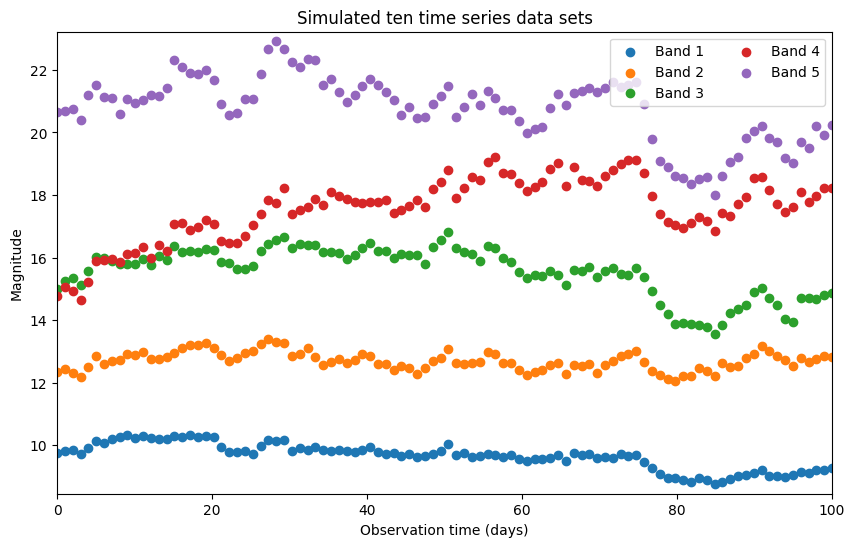

In [17]:
np.random.seed(42)
# 변수 설정 및 데이터 생성 코드
n = 100
n_datasets = 5  # 데이터셋 수 변경
obs_time = np.linspace(0, 100, n)
#obs_time = np.cumsum(gamma.rvs(a=3, scale=1, size=n))
# 배열 크기를 n_datasets에 맞추어 조정합니다.
mu = np.linspace(10, 22, n_datasets)  # 예시: 13부터 19까지 등간격으로
sigma = np.linspace(0.1, 0.4, n_datasets)  # 예시: 0.1부터 0.2까지 등간격으로
tau = np.linspace(90, 110, n_datasets)  # 예시: 80부터 110까지 등간격으로
rho = np.full((n_datasets * (n_datasets - 1) // 2), 0.8) # 모든 비대각선 원소에 대해 동일한 상관계수 사용
measure_error_band = np.linspace(0.04, 0.06, n_datasets)  # 예시: 0.01부터 0.05까지 등간격으로

measure_error = None
for i in range(n_datasets):
    error_component = np.random.normal(measure_error_band[i], 0.002, n)
    measure_error = np.column_stack([measure_error, error_component]) if measure_error is not None else error_component

# # 상관 행렬 생성
# rho_mat = np.full((n_datasets, n_datasets), rho_value)
# np.fill_diagonal(rho_mat, 1)  # 자기 자신과의 상관계수는 1로 설정

x = simulate_data(time=obs_time, n_datasets=n_datasets, measure_error_SD=measure_error, mu=mu, sigma=sigma, tau=tau, rho=rho)

# 데이터와 obs_time을 이용한 시각화
plt.figure(figsize=(10, 6))
for i in range(n_datasets):
    plt.scatter(obs_time, x[:, i], label=f'Band {i+1}')

plt.xlim(min(obs_time), max(obs_time))
plt.ylim(np.amin(x) - 0.3, np.amax(x) + 0.3)
plt.xlabel("Observation time (days)")
plt.ylabel("Magnitude")
plt.title("Simulated ten time series data sets")
plt.legend(loc='upper right', ncol=2)
plt.show()

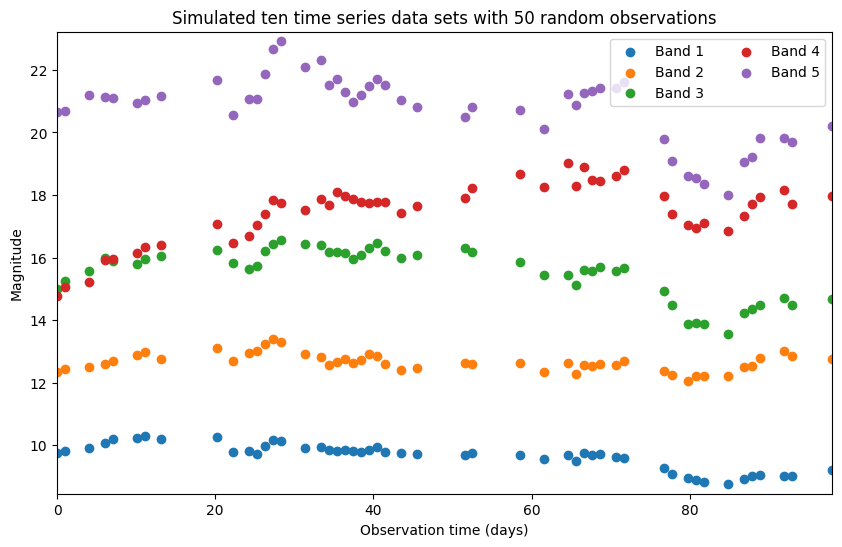

In [18]:
random_indices = np.random.choice(n, 50, replace=False)
random_obs_time = obs_time[random_indices]
random_x = x[random_indices, :]
# random_obs_time을 시간 순서대로 정렬하고, 인덱스를 가져옵니다.
sorted_indices = np.argsort(random_obs_time)
sorted_random_obs_time = random_obs_time[sorted_indices]

# sorted_indices를 사용하여 random_x도 동일한 순서로 정렬합니다.
sorted_random_x = random_x[sorted_indices, :]

# sorted_random_x 배열을 [n_datasets, 50, 1] 형태로 변경
sorted_random_x_reshaped = np.reshape(sorted_random_x.T, (n_datasets, 50, 1))
# 데이터와 random_obs_time을 이용한 시각화
plt.figure(figsize=(10, 6))
for i in range(n_datasets):
    plt.scatter(random_obs_time, random_x[:, i], label=f'Band {i+1}')

plt.xlim(min(random_obs_time), max(random_obs_time))
plt.ylim(np.amin(random_x) - 0.3, np.amax(random_x) + 0.3)
plt.xlabel("Observation time (days)")
plt.ylabel("Magnitude")
plt.title("Simulated ten time series data sets with 50 random observations")
plt.legend(loc='upper right', ncol=2)
plt.show()

# 모델에 사용할 dataset

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# CustomTimeSeriesDataset 클래스 정의
class CustomTimeSeriesDataset(Dataset):
    def __init__(self, n_datasets, n_samples, obs_time, mu, sigma, tau, measure_error_band):
        np.random.seed(42)
        self.n_datasets = n_datasets
        self.n_samples = n_samples
        self.obs_time = obs_time
        self.mu = mu
        self.sigma = sigma
        self.tau = tau

        # 측정 오류 생성
        measure_error = None
        for i in range(n_datasets):
            error_component = np.random.normal(measure_error_band[i], 0.002, len(obs_time))
            measure_error = np.column_stack([measure_error, error_component]) if measure_error is not None else error_component

        self.data = self.simulate_data(obs_time, n_datasets, measure_error, mu, sigma, tau)
        
        # 50개의 랜덤한 관측값 선택 및 정렬
        self.select_and_sort_samples()

    def simulate_data(self, time, n_datasets, measure_error_SD, mu, sigma, tau):
        n = len(time)
        x = np.zeros((n, n_datasets))
        for i in range(n_datasets):
            x[:, i] = mu[i] + sigma[i] * np.sin(2 * np.pi * time / tau[i]) + measure_error_SD[:, i]
        return x

    def select_and_sort_samples(self):
        random_indices = np.random.choice(len(self.obs_time), self.n_samples, replace=False)
        self.sorted_indices = np.argsort(self.obs_time[random_indices])
        self.sorted_random_obs_time = self.obs_time[random_indices][self.sorted_indices]
        
        sorted_random_x = self.data[random_indices, :][self.sorted_indices]
        self.sorted_random_x_reshaped = np.reshape(sorted_random_x.T, (self.n_datasets, self.n_samples, 1))

    def __len__(self):
        return self.n_datasets

    def __getitem__(self, idx):
        return torch.tensor(self.sorted_random_obs_time, dtype=torch.float32), torch.tensor(self.sorted_random_x_reshaped[idx], dtype=torch.float32)

# 데이터셋 설정
n_datasets = 5
n_samples = 50
obs_time = np.linspace(0, 100, 50)
mu = np.linspace(10, 22, n_datasets)
sigma = np.linspace(0.1, 0.4, n_datasets)
tau = np.linspace(90, 110, n_datasets)
measure_error_band = np.linspace(0.04, 0.06, n_datasets)
# 데이터셋 클래스 정의는 동일하게 유지하며, 데이터 로더 부분에 대해 정규화를 추가합니다.

# 정규화 함수 정의
# CustomTimeSeriesDataset 클래스 재정의를 포함하여, 정규화된 데이터셋을 사용하기 위한 코드를 실행합니다.

class NormalizedCustomTimeSeriesDataset(CustomTimeSeriesDataset):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # 데이터 정규화 (n_datasets 별로 정규화)
        self.normalized_data = np.zeros_like(self.data)
        for i in range(self.n_datasets):
            self.normalized_data[:, i] = (self.data[:, i] - np.mean(self.data[:, i])) / np.std(self.data[:, i])

    def __getitem__(self, idx):
        # 시간 데이터는 정규화하지 않고, 관측 데이터만 정규화하여 반환합니다.
        # 반환되는 시간 데이터의 크기를 50으로 조정합니다.
        return (torch.tensor(self.normalized_data[:, idx], dtype=torch.float32).view(self.n_samples, 1))

# 데이터셋 인스턴스 생성
dataset = NormalizedCustomTimeSeriesDataset(n_datasets, n_samples, obs_time, mu, sigma, tau, measure_error_band)

# 데이터셋을 훈련 및 테스트 세트로 분할
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
normalized_train_dataset, normalized_test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# DataLoader 설정
train_loader = DataLoader(normalized_train_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(normalized_test_dataset, batch_size=1, shuffle=False)

# 첫 번째 배치의 정규화된 데이터 확인
normalized_first_batch_shapes = {}
for name, loader in zip(["train", "test"], [train_loader, test_loader]):
    normalized_values = next(iter(loader))
    normalized_first_batch_shapes[name] = {"values_shape": normalized_values.shape}

normalized_first_batch_shapes

# dataset = CustomTimeSeriesDataset(n_datasets, n_samples, obs_time, mu, sigma, tau, measure_error_band)

# # 데이터셋을 훈련 및 테스트 세트로 분할
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# # DataLoader 설정
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# # 배치 사이즈 및 아이템 shape 확인
# batch_counts = {"train": len(train_loader), "test": len(test_loader)}
# first_batch_shapes = {}

# # 첫 번째 배치의 shape 확인
# for name, loader in zip(["train", "test"], [train_loader, test_loader]):
#     times, values = next(iter(loader))
#     first_batch_shapes[name] = {"times_shape": times.shape, "values_shape": values}

# batch_counts, first_batch_shapes


{'train': {'values_shape': torch.Size([4, 50, 1])},
 'test': {'values_shape': torch.Size([1, 50, 1])}}

# 모델링

In [20]:
import torch
import torch.nn as nn
from torchdiffeq import odeint

# Encoder class
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_layer_depth=1):
        super(Encoder, self).__init__()
        self.number_of_features = input_size
        self.hidden_size = hidden_size
        self.hidden_layer_depth = hidden_layer_depth
        self.model = nn.LSTM(self.number_of_features, self.hidden_size, 
                             self.hidden_layer_depth, batch_first=True)

    def forward(self, x):
        _, (h_end, c_end) = self.model(x)
        return h_end

# Reparameterization function
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    eps = torch.randn_like(std)
    return mu + eps * std

# Lambda class
class Lambda(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Lambda, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.hidden_to_mean = nn.Linear(self.hidden_size, self.output_size)
        self.hidden_to_logvar = nn.Linear(self.hidden_size, self.output_size)
        nn.init.xavier_uniform_(self.hidden_to_mean.weight)
        nn.init.xavier_uniform_(self.hidden_to_logvar.weight)

    def forward(self, cell_output):
        latent_mean = self.hidden_to_mean(cell_output)
        latent_logvar = self.hidden_to_logvar(cell_output)
        z = reparameterization(latent_mean, latent_logvar)
        return z, latent_mean, latent_logvar


class ODESolver(nn.Module):
    def __init__(self, latent_dim):
        super(ODESolver, self).__init__()
        self.odefunc = nn.Sequential(
            nn.Linear(latent_dim, 50),
            nn.ReLU(),
            nn.Linear(50, latent_dim),
        )

    def forward(self, t, z):
        return self.odefunc(z)

class Decoder(nn.Module):
    def __init__(self, latent_dim, time_steps, output_dim=1):
        super(Decoder, self).__init__()
        # 선형 변환의 출력 크기를 time_steps * output_dim으로 설정
        self.fc = nn.Linear(latent_dim, time_steps * output_dim)
        self.time_steps = time_steps
        self.output_dim = output_dim

    def forward(self, z_traj):
        # z_traj의 형태: (time_steps, batch_size, latent_dim)
        batch_size = z_traj.size(1)
        # 모든 시간 스텝에 대해 출력을 생성
        out = self.fc(z_traj.reshape(-1, z_traj.size(-1)))
        # 출력의 형태를 (batch_size, time_steps, output_dim)으로 재구성
        out = out.view(batch_size, self.time_steps, self.output_dim)
        return out


class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, latent_dim,hidden_layer_depth=1):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, hidden_layer_depth)
        self.lambda_layer = Lambda(hidden_size, latent_dim)
        self.odesolver = ODESolver(latent_dim)
        self.decoder = Decoder(latent_dim, output_size)

    def forward(self, x, t):
        h_end = self.encoder(x)
        z, mu, logvar = self.lambda_layer(h_end[-1])
        z_traj = odeint(self.odesolver, z, t)
        # Decoder에 전체 z_traj를 전달
        out = self.decoder(z_traj.transpose(0, 1))
    
        return out, mu, logvar, z_traj

# train

In [21]:
input_size = 1  # Adjust based on your dataset
hidden_size = 20  # Example value
output_size = 1  # Adjust based on your dataset
latent_dim = 10  # Example value
hidden_layer_depth = 1  # Example value
model = VAE(input_size, hidden_size, output_size, latent_dim, hidden_layer_depth)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [22]:
import torch.nn.functional as F
def elbo_loss(reconstructed_x, x, mu, logvar):
    # Reconstruction Loss 계산
    reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')

    # KL Divergence 계산
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reconstruction_loss + kl_divergence

In [23]:
predict_time = torch.tensor(sorted_random_obs_time,device=device) 

In [24]:
predict_time.shape

torch.Size([50])

In [26]:
num_epochs = 3000  # 예시 값
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for values in train_loader:
        optimizer.zero_grad()
        reconstructed_x, mu, logvar, _ = model(values, predict_time)
        loss = elbo_loss(reconstructed_x, values.squeeze(), mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader)}")

RuntimeError: shape '[50, 1, 1]' is invalid for input of size 200

/tmp/ipykernel_3967657/2865605383.py:4: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  reconstruction_loss = F.mse_loss(reconstructed_x, x, reduction='sum')
/tmp/ipykernel_3967657/3897725048.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15, 6))


KeyboardInterrupt: 

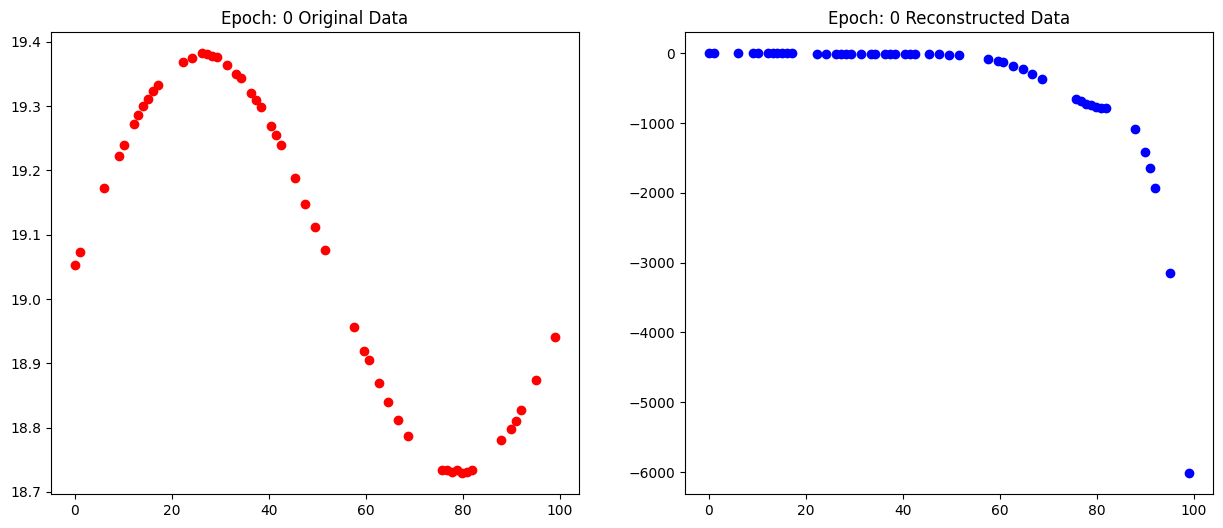

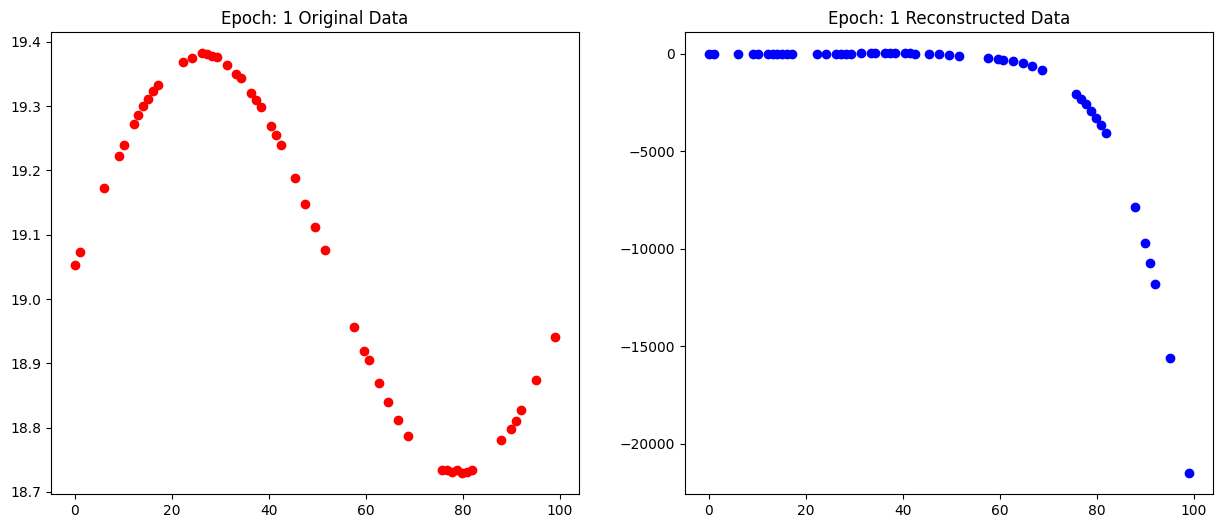

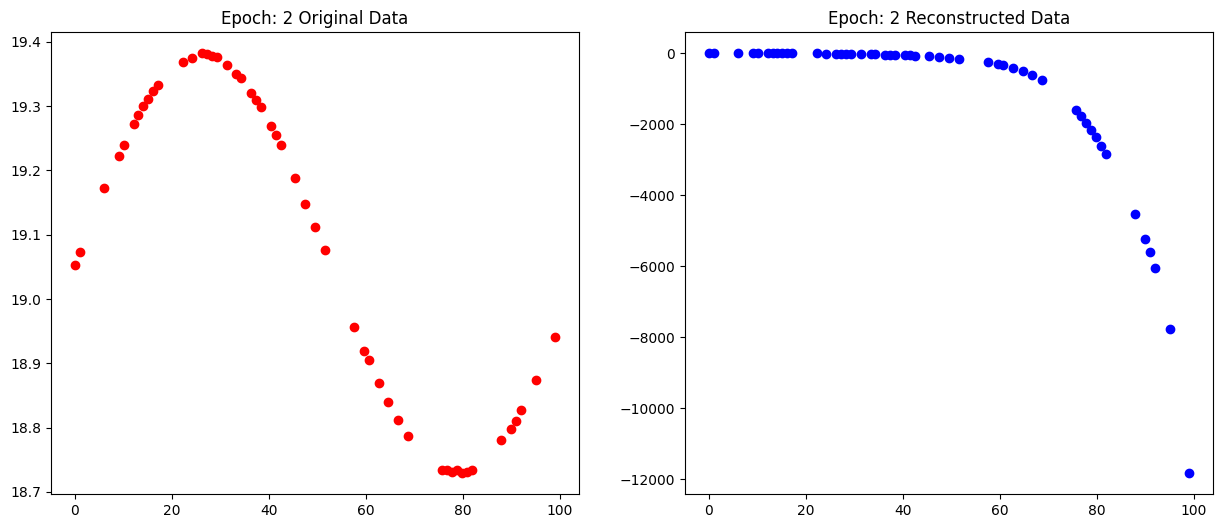

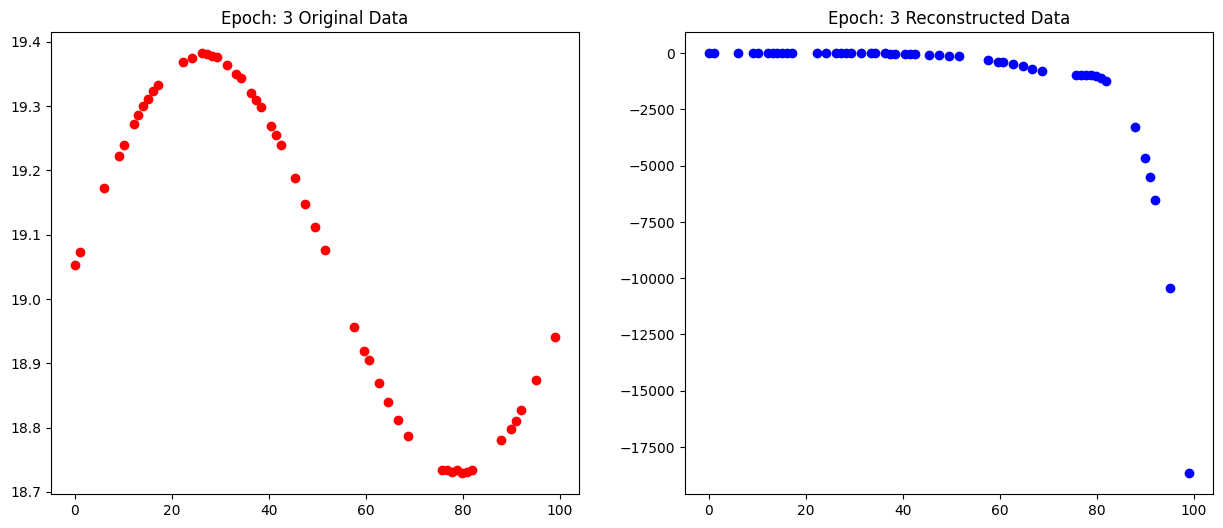

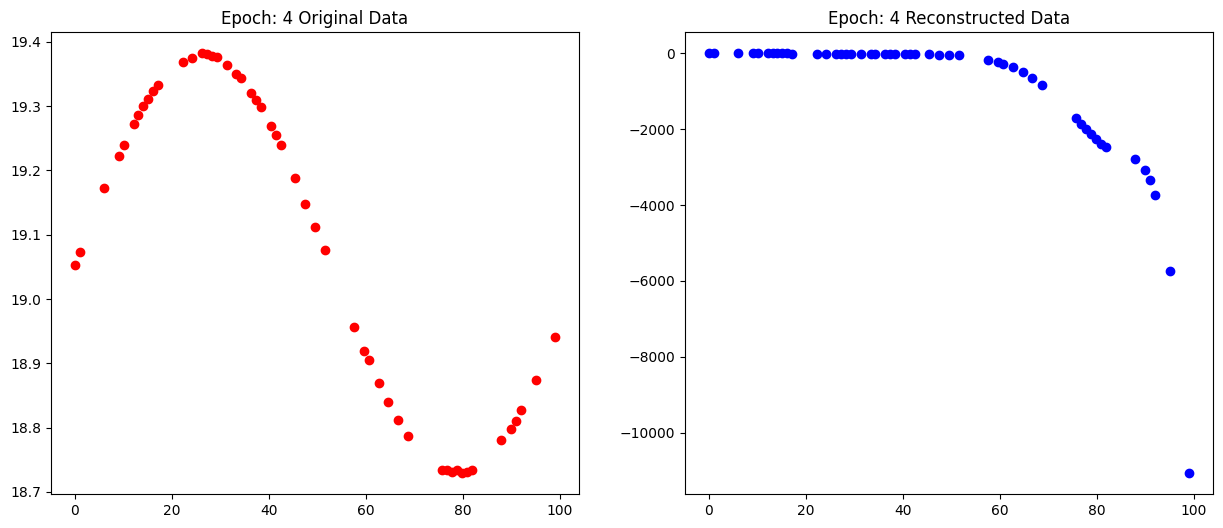

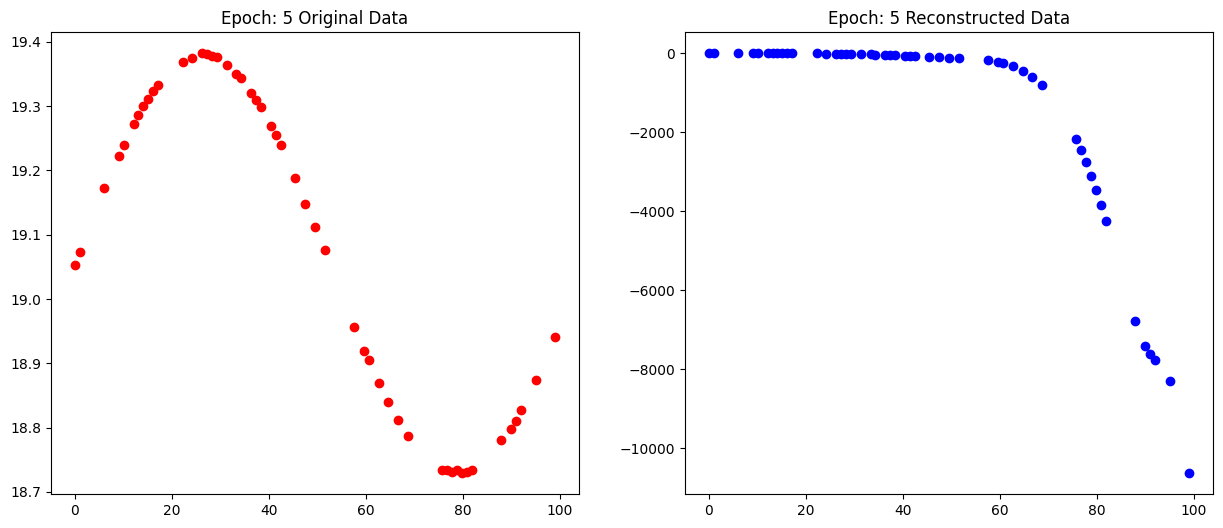

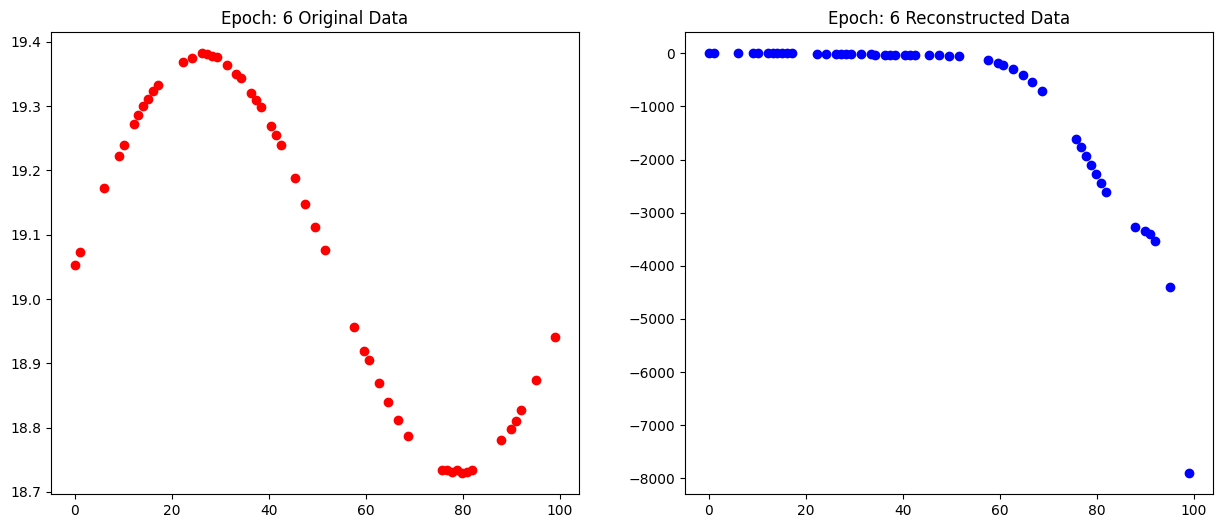

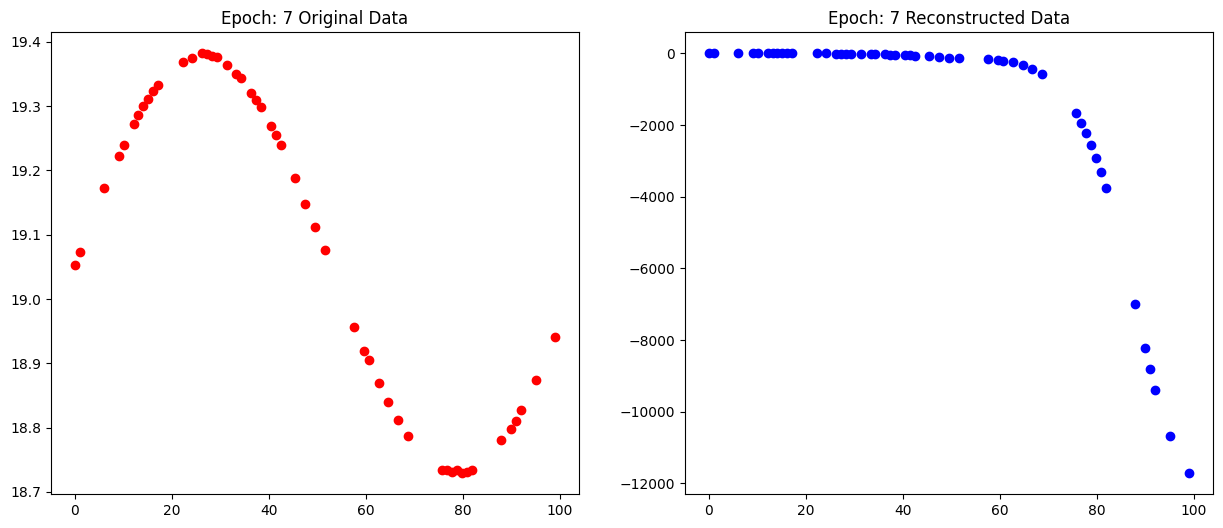

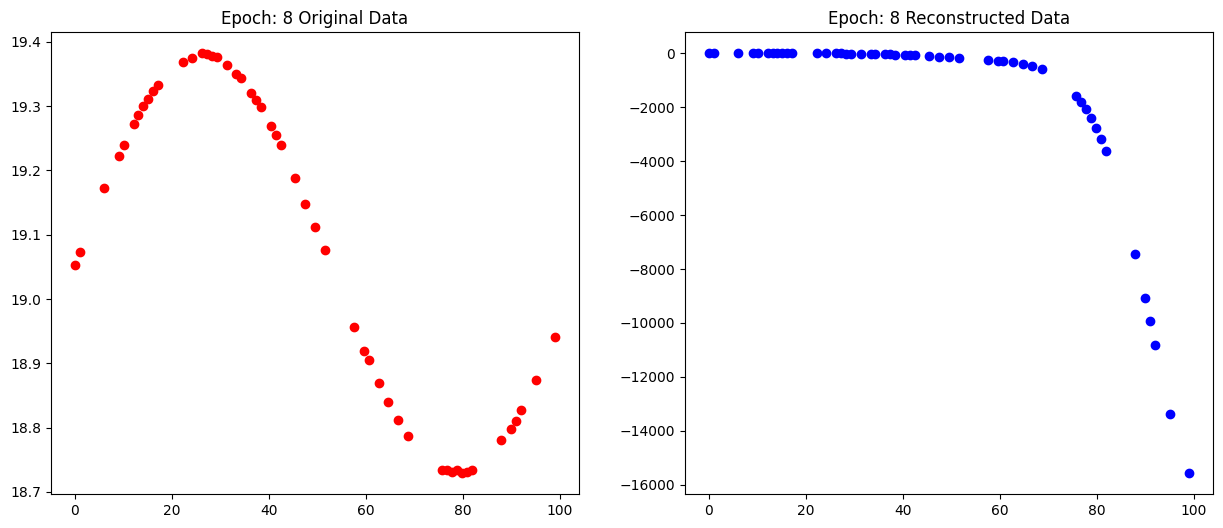

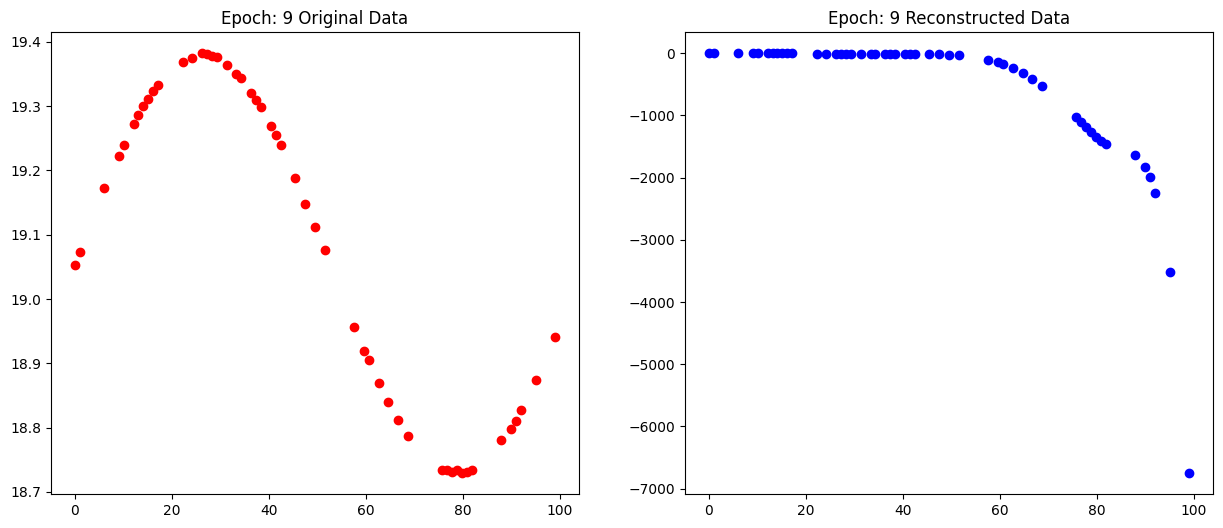

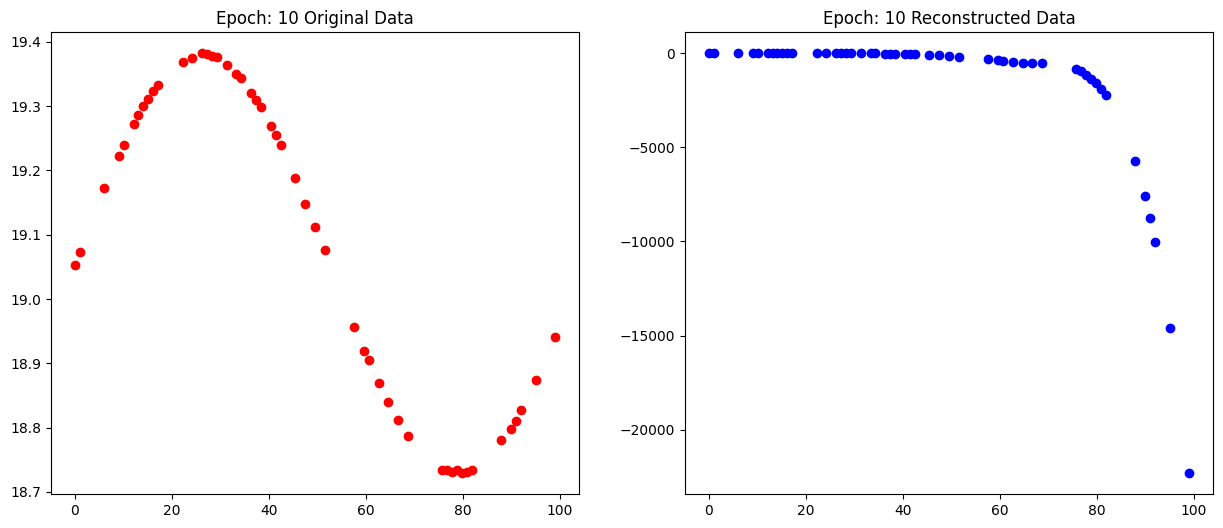

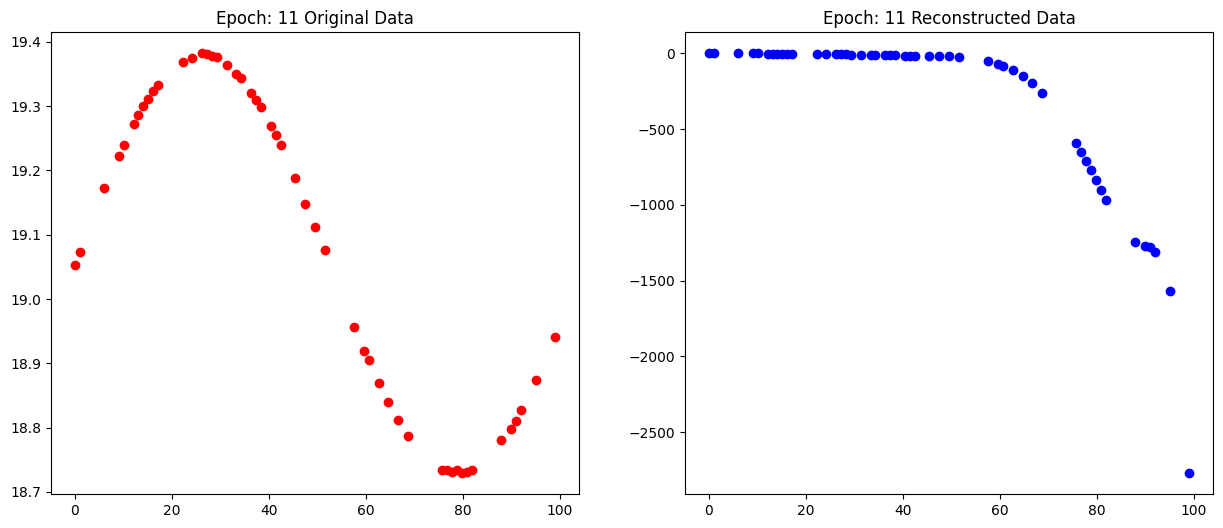

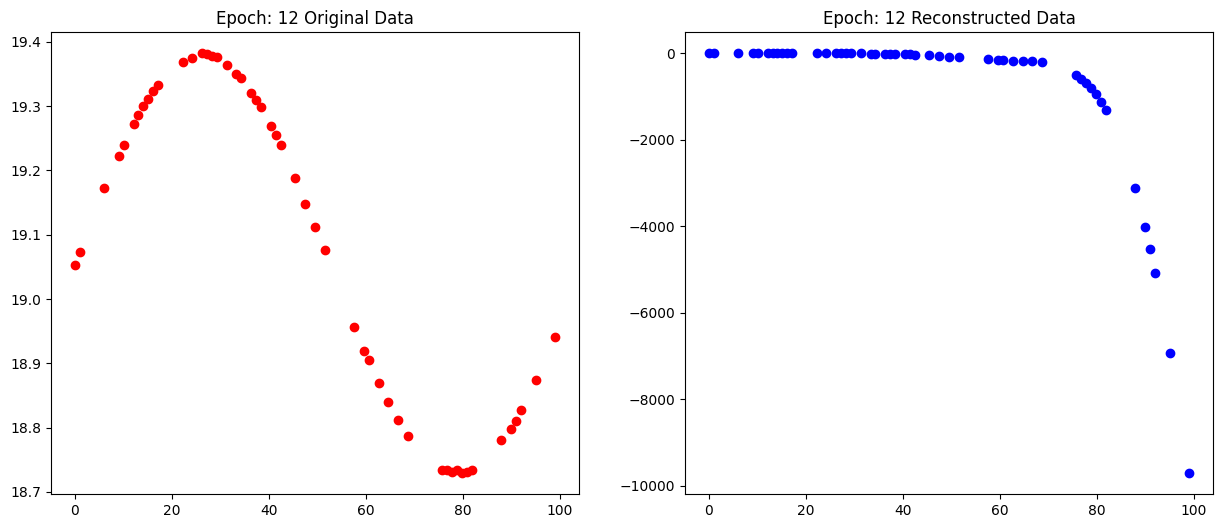

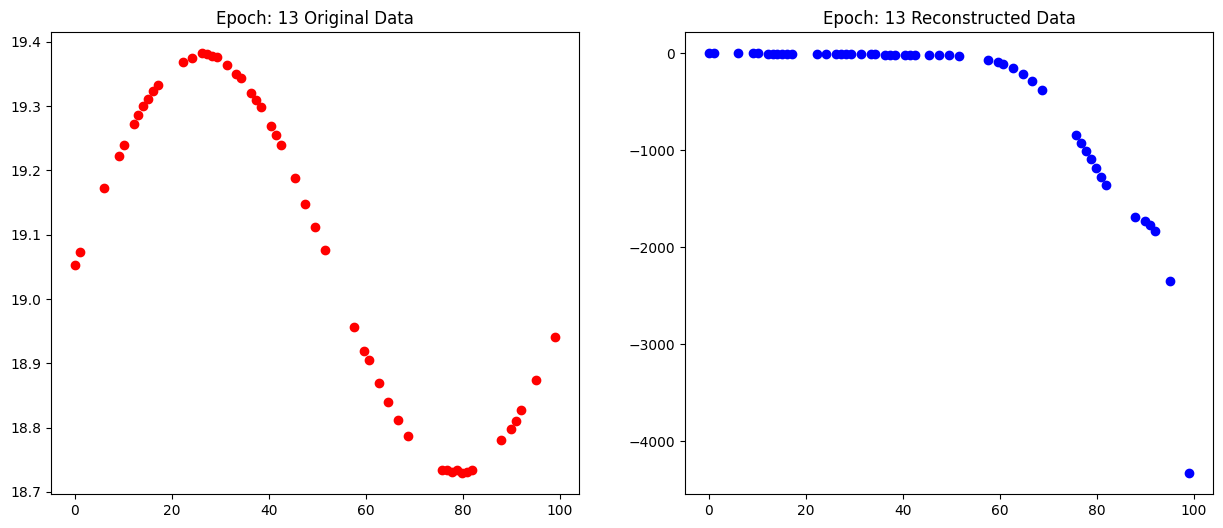

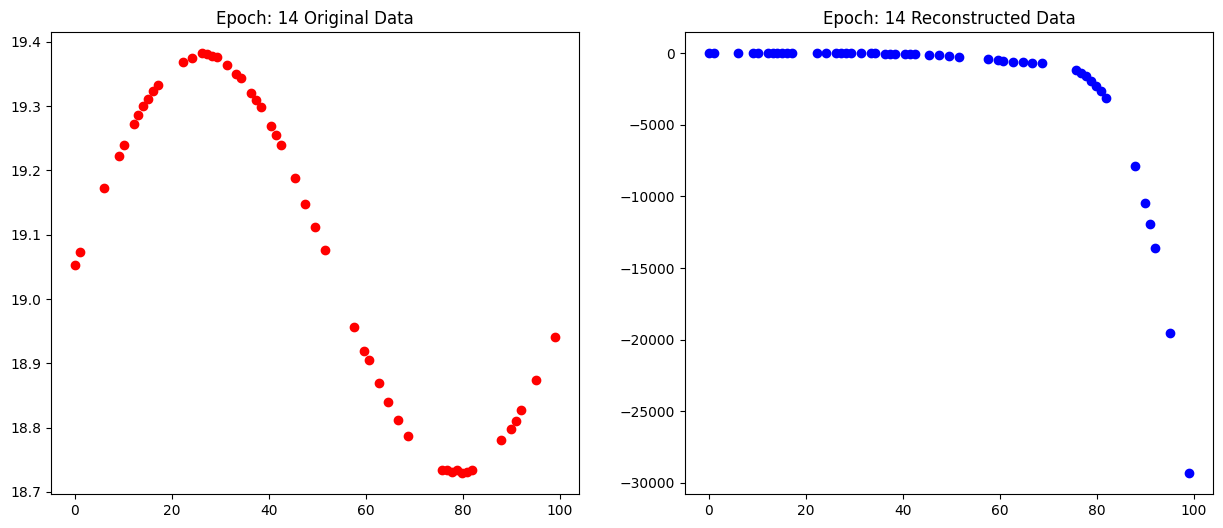

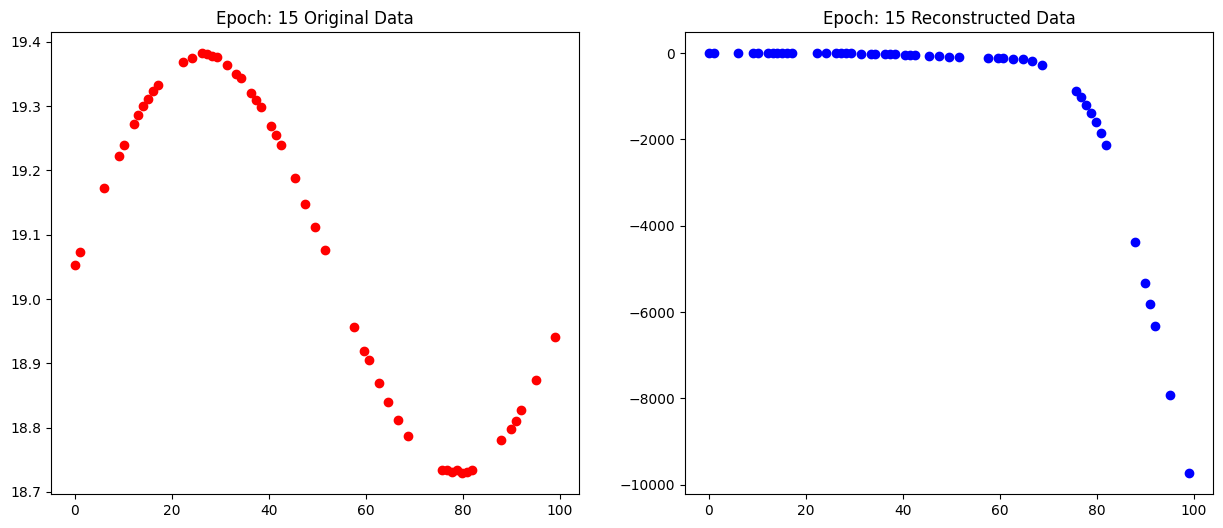

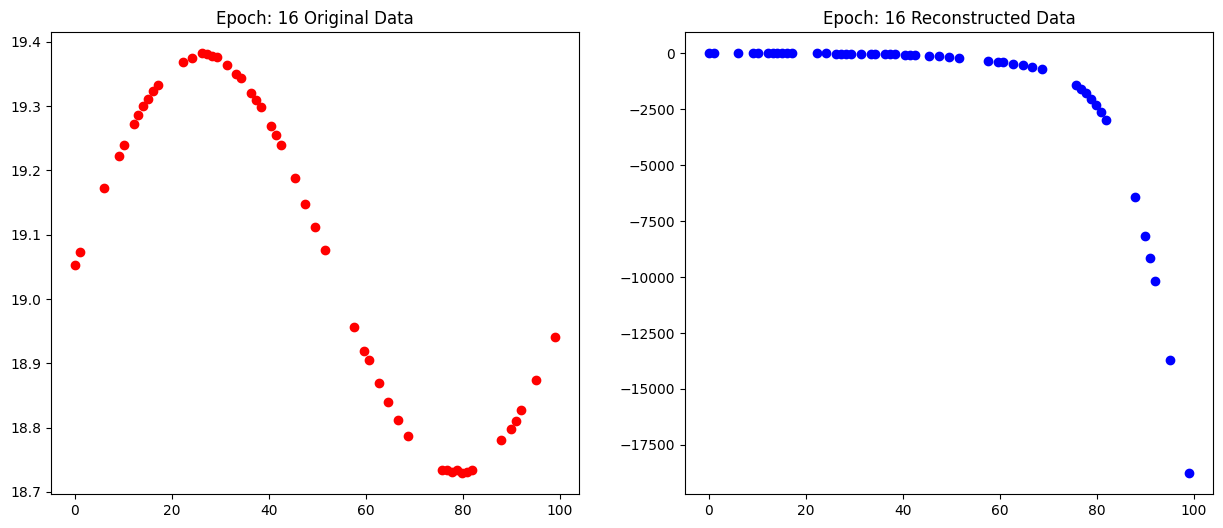

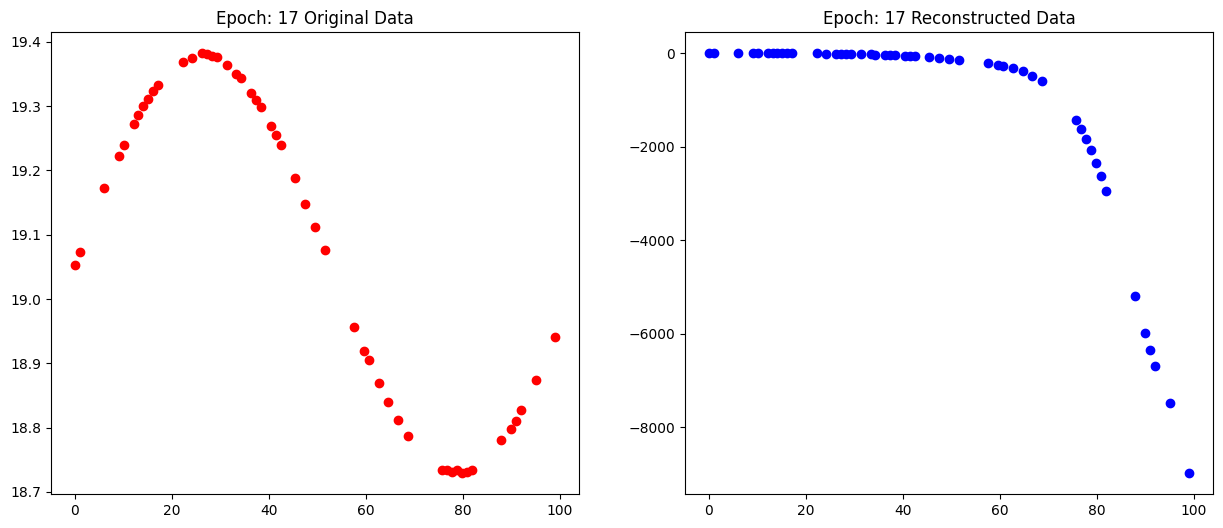

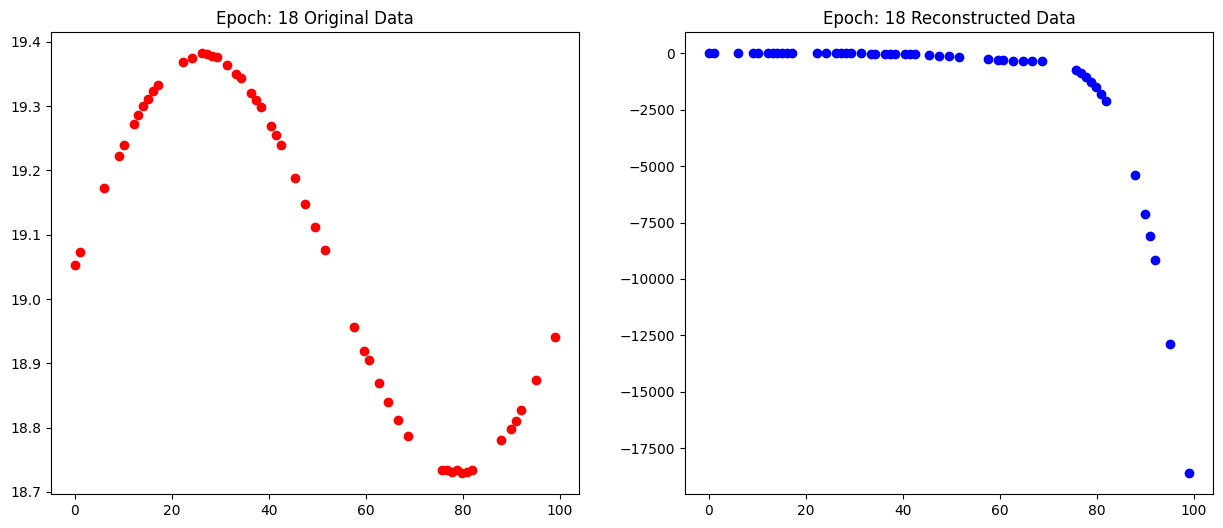

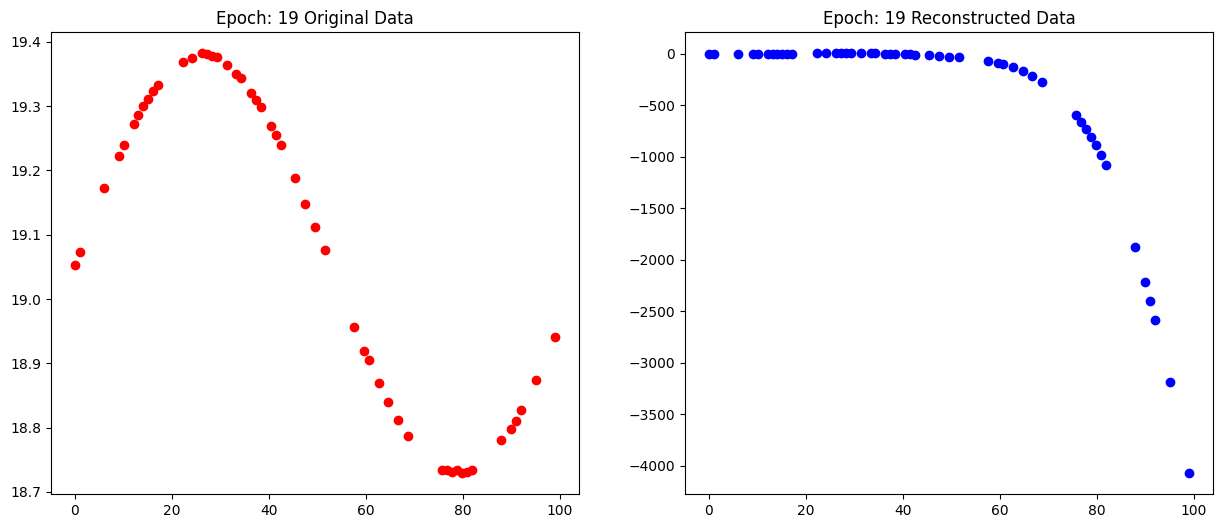

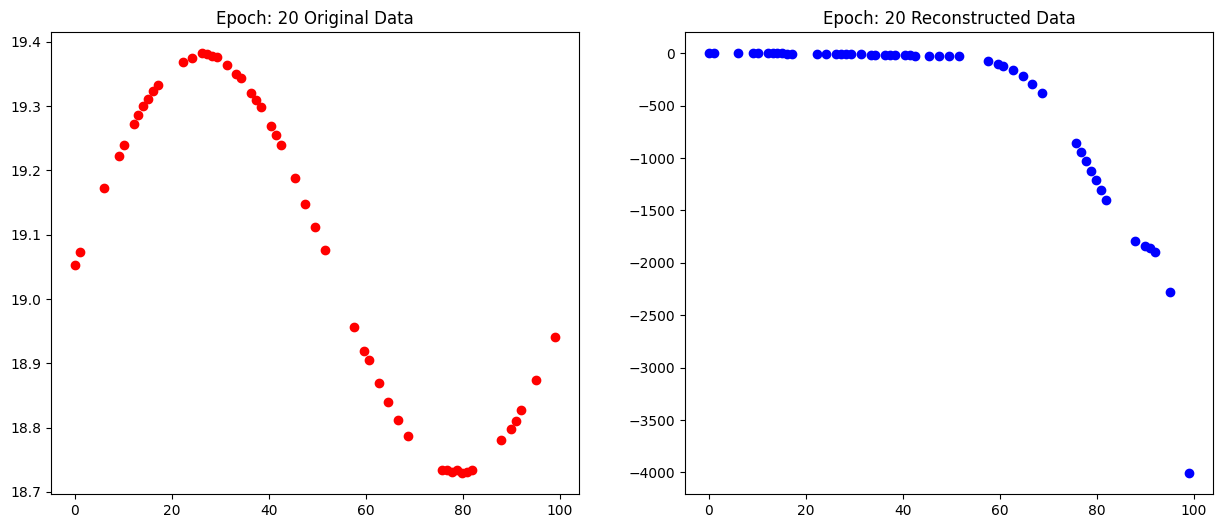

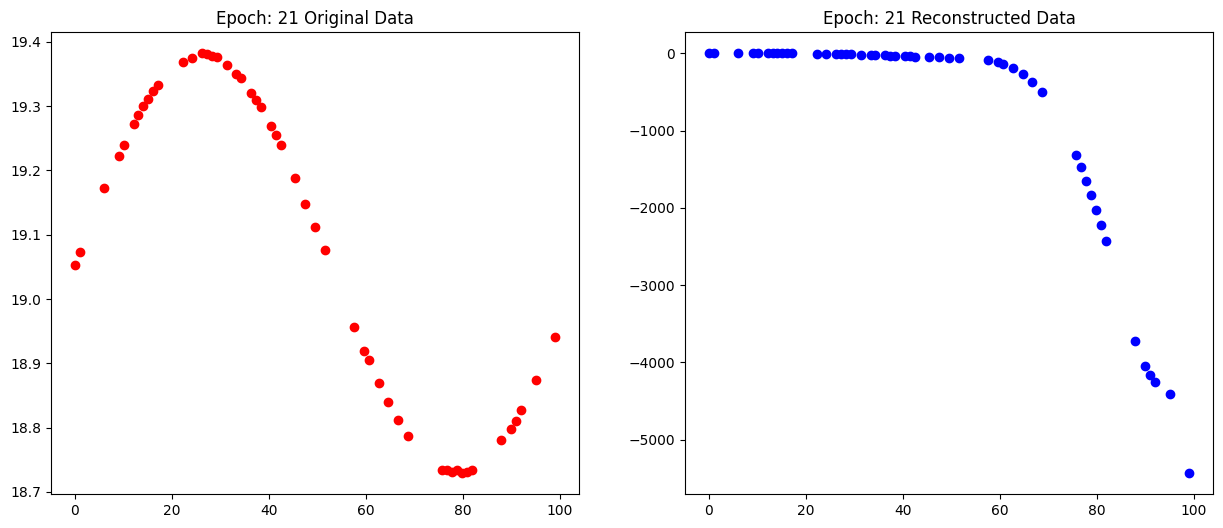

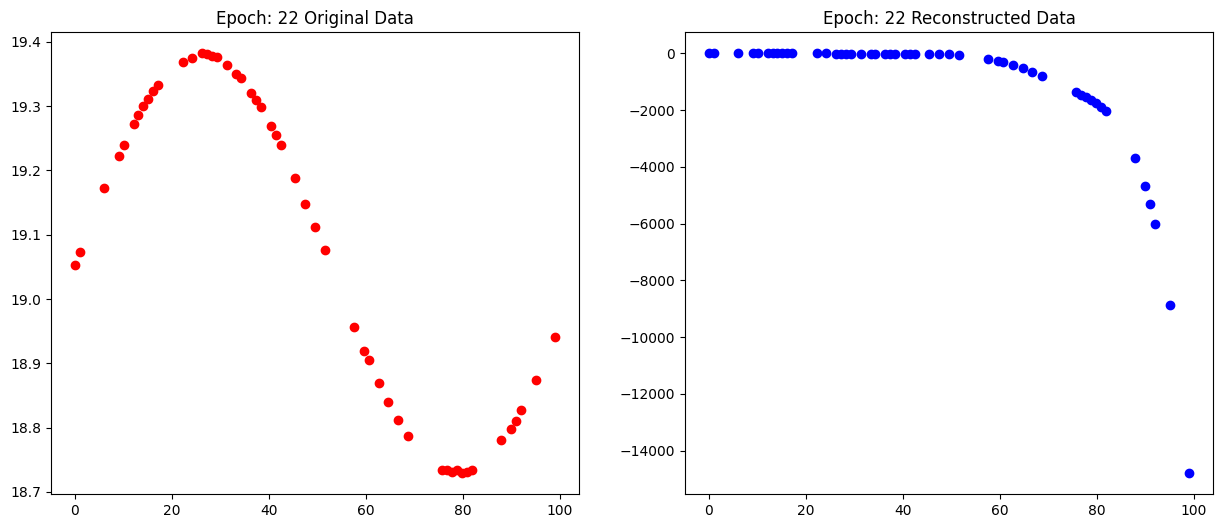

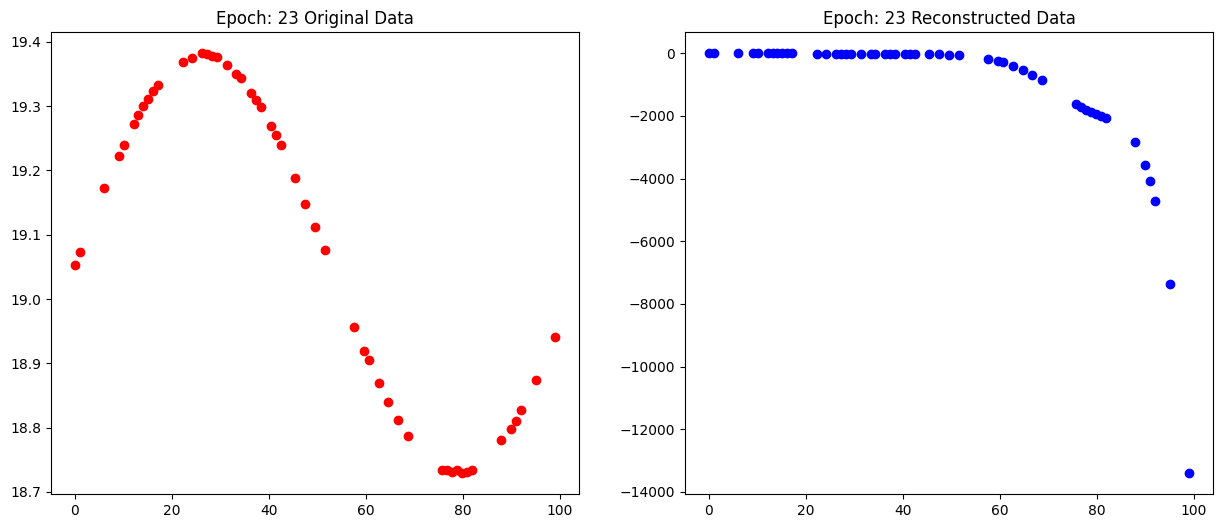

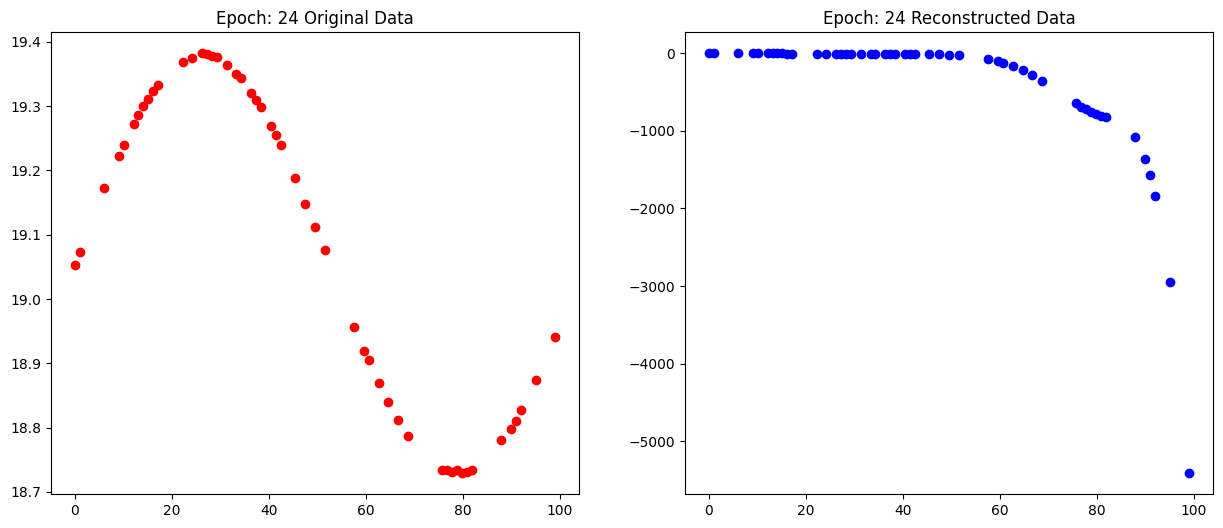

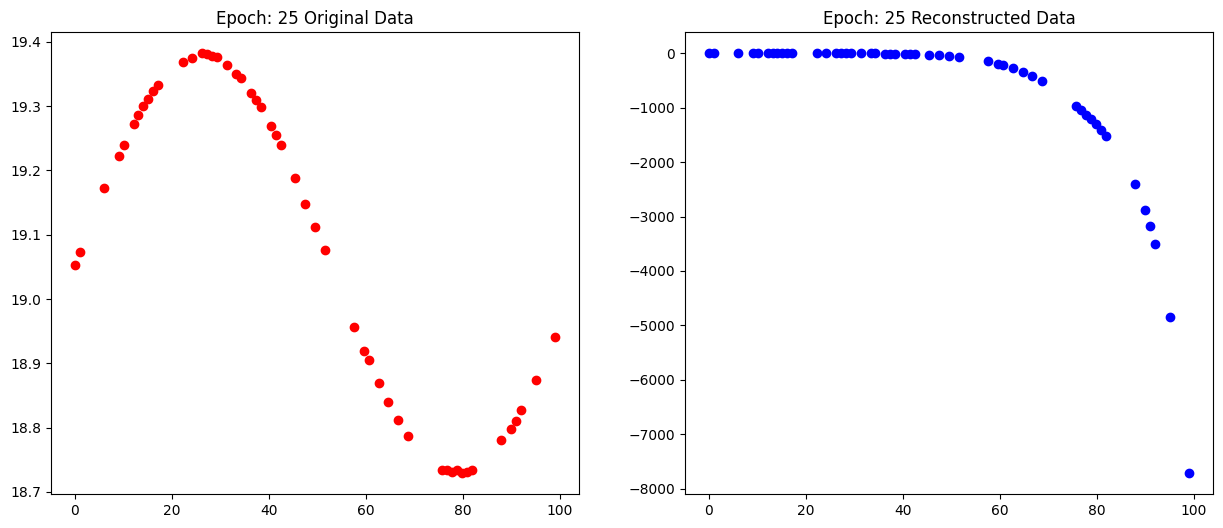

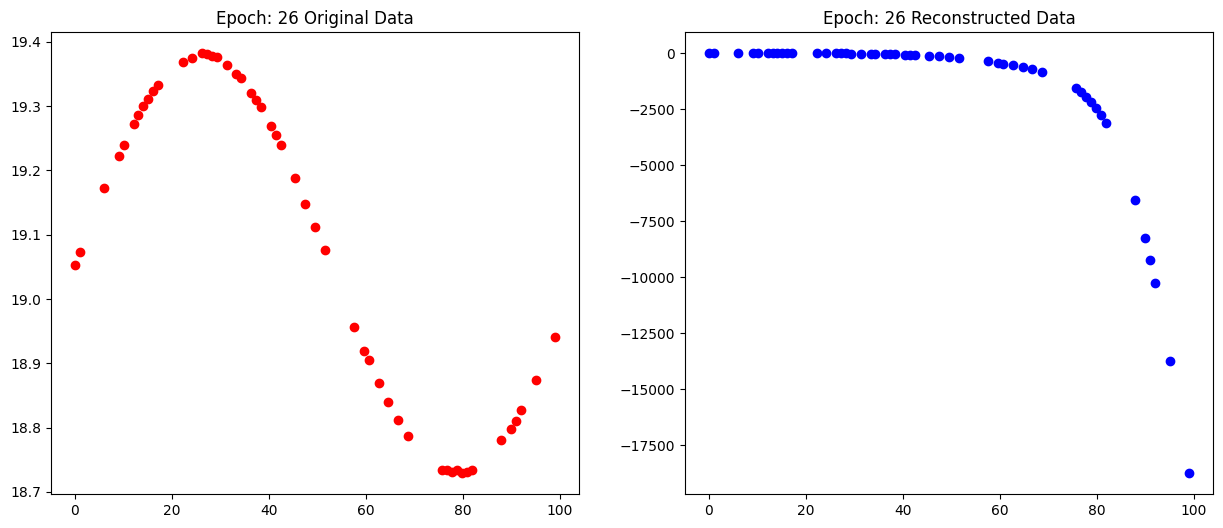

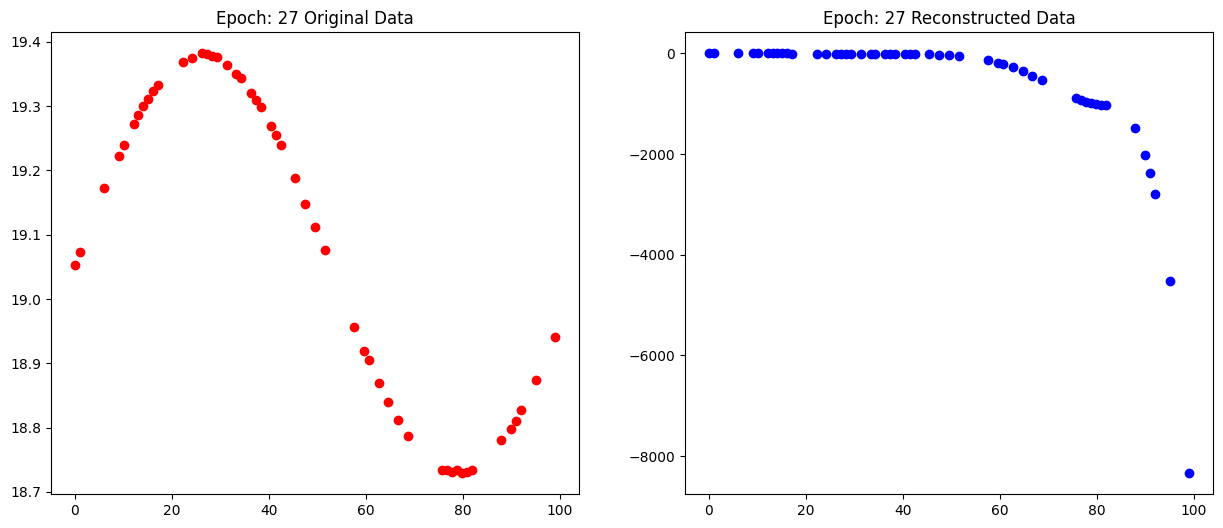

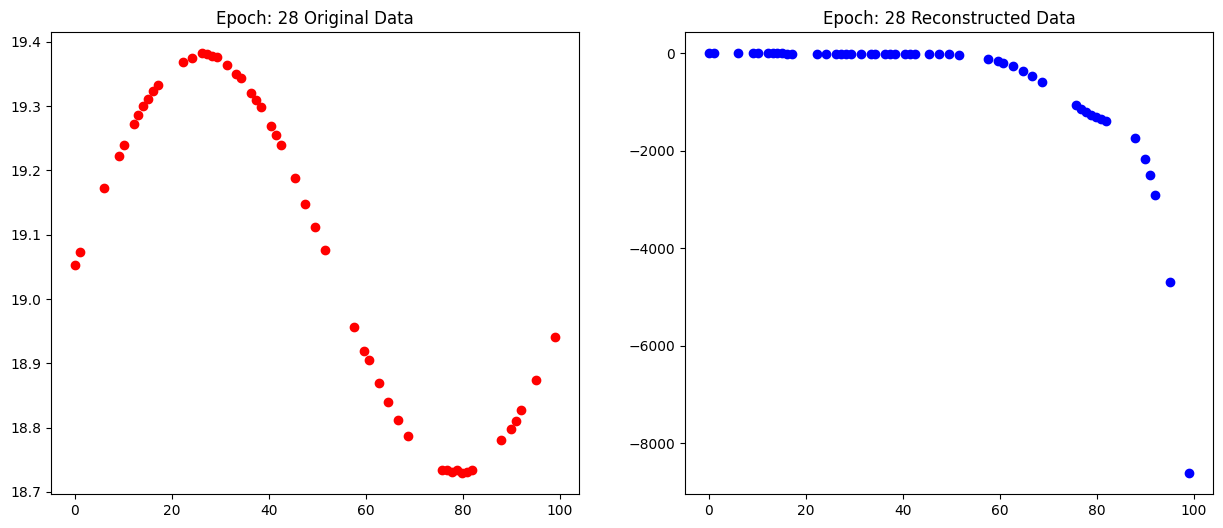

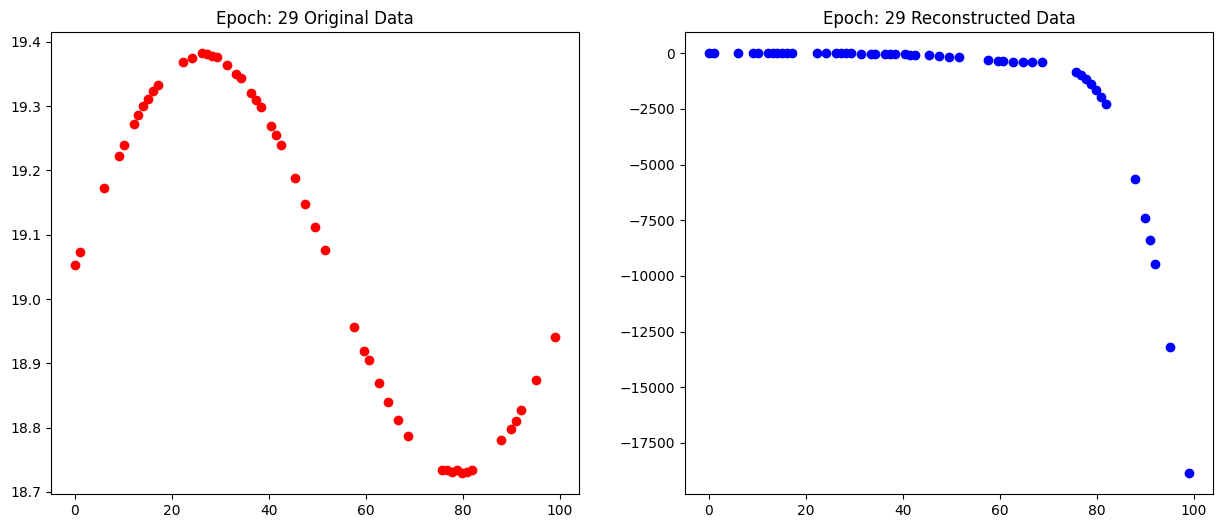

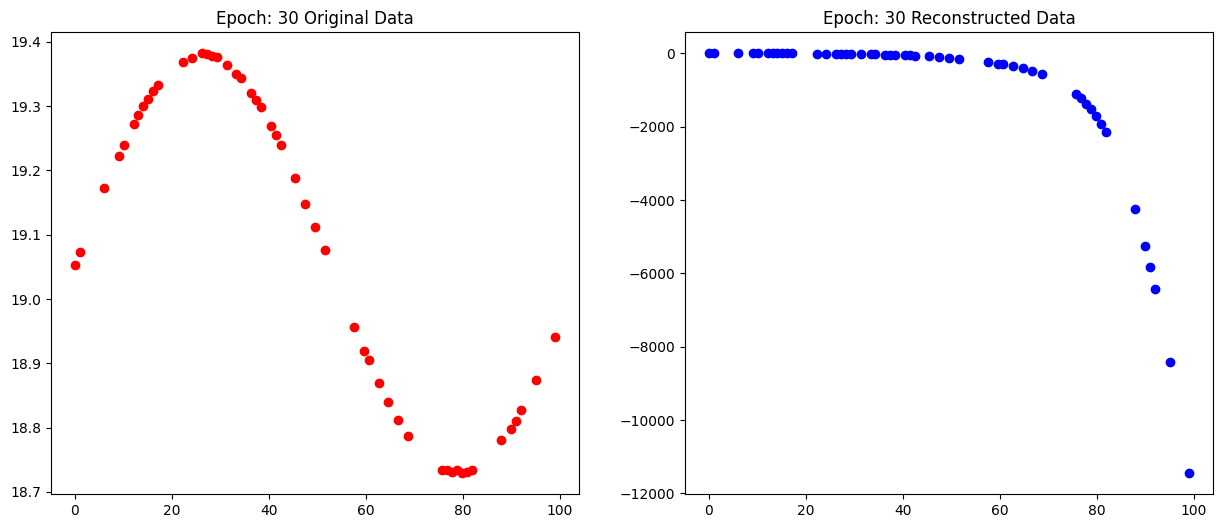

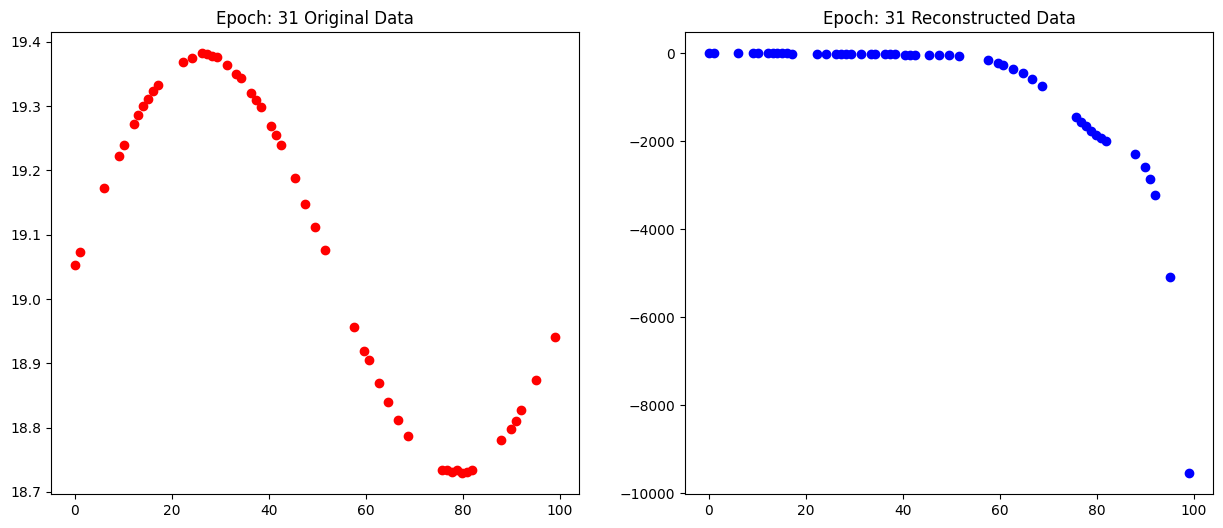

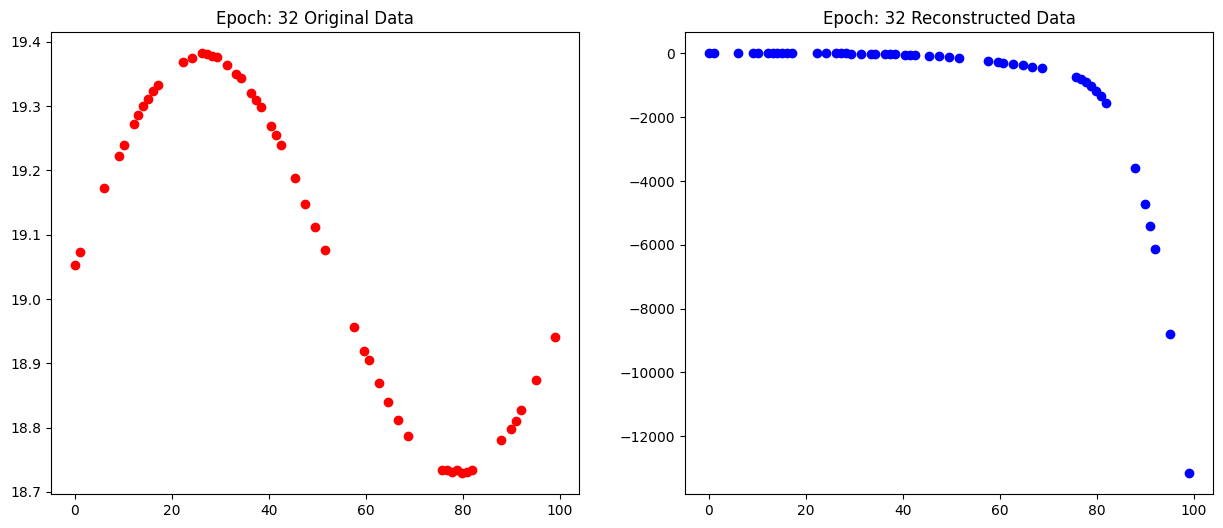

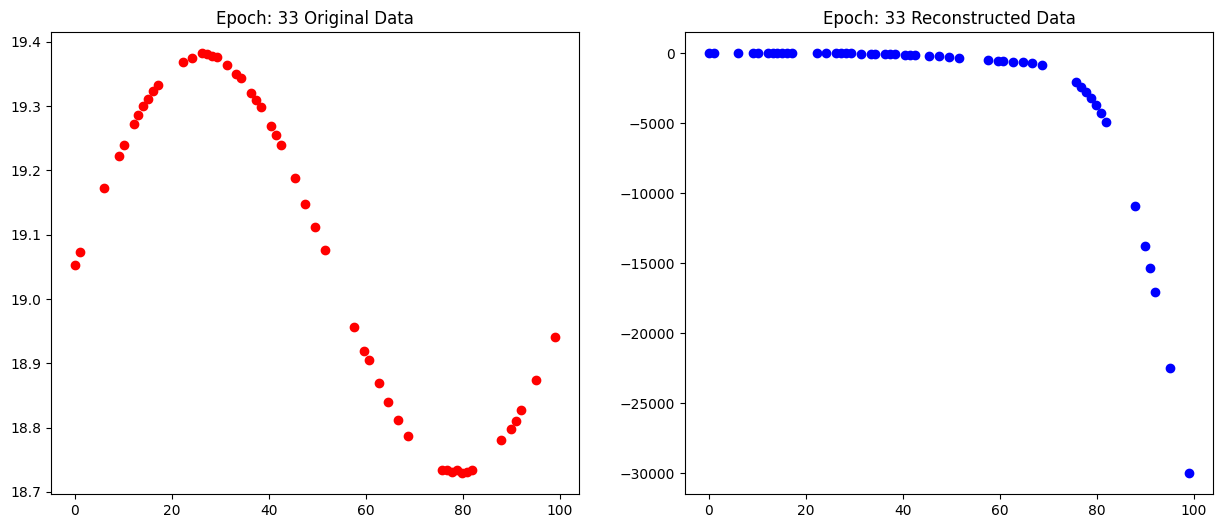

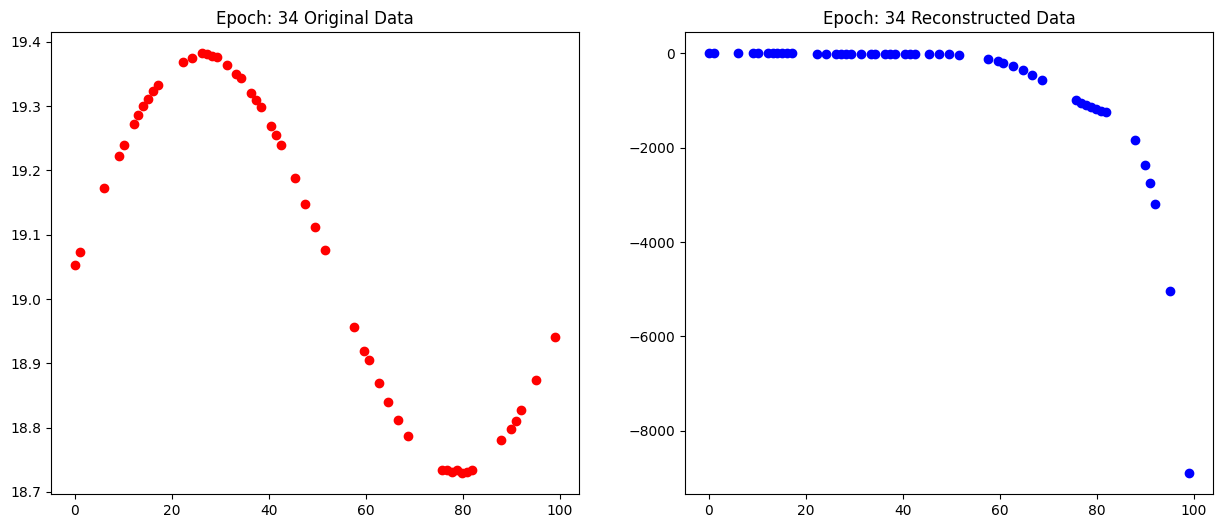

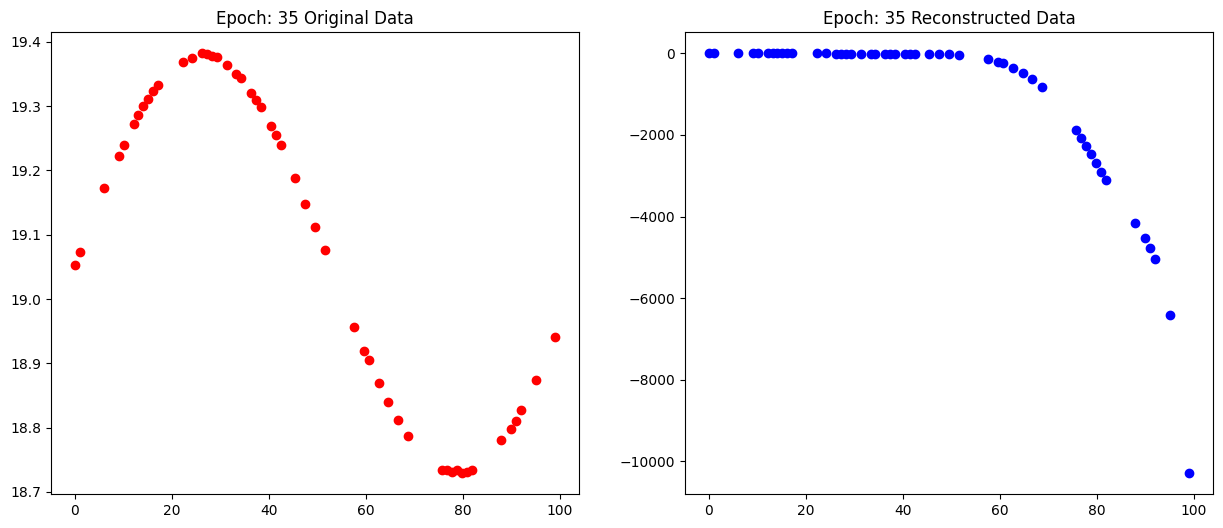

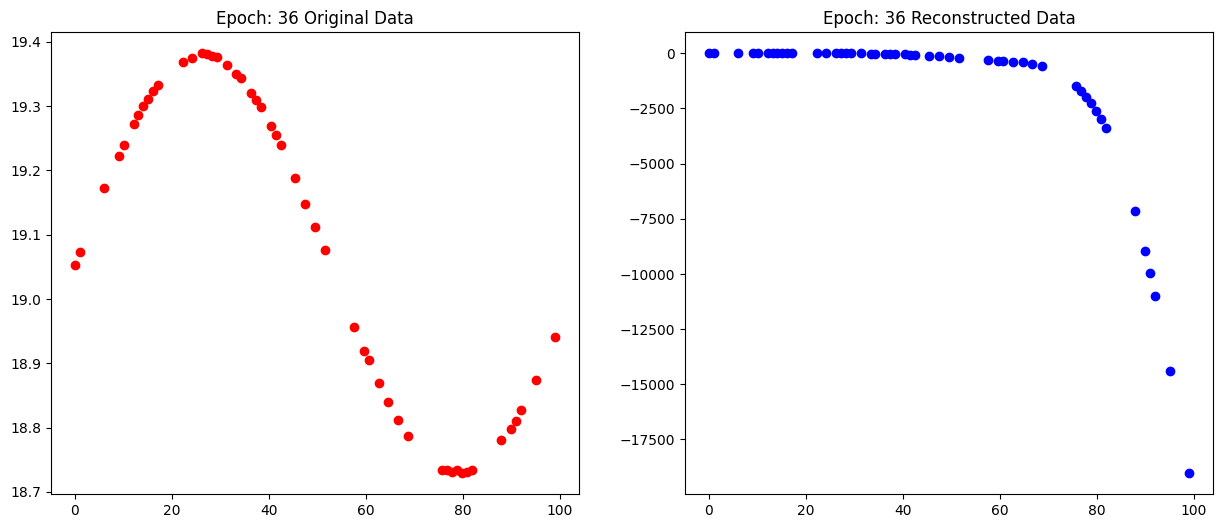

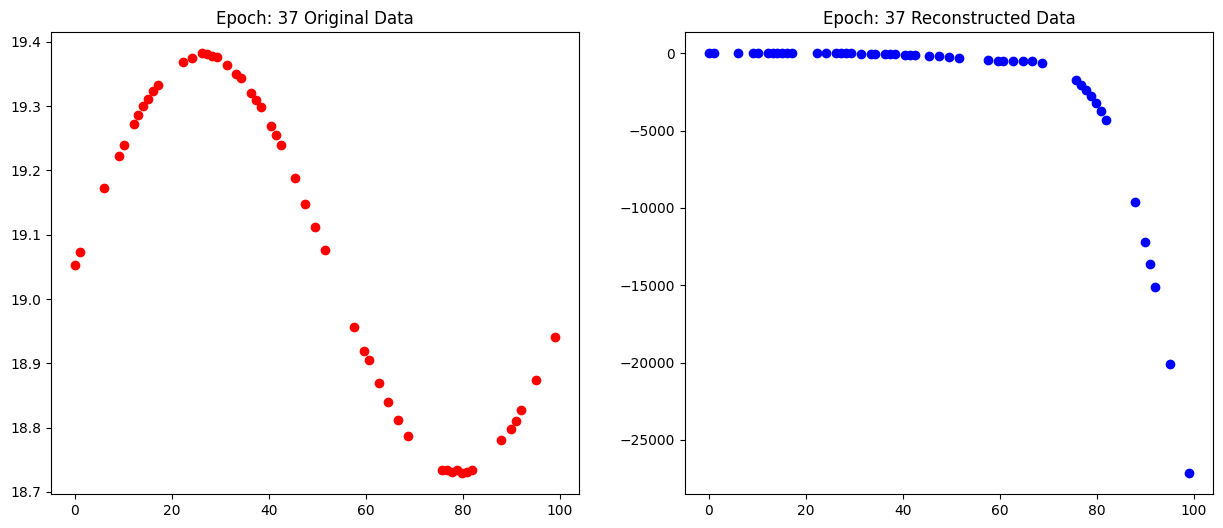

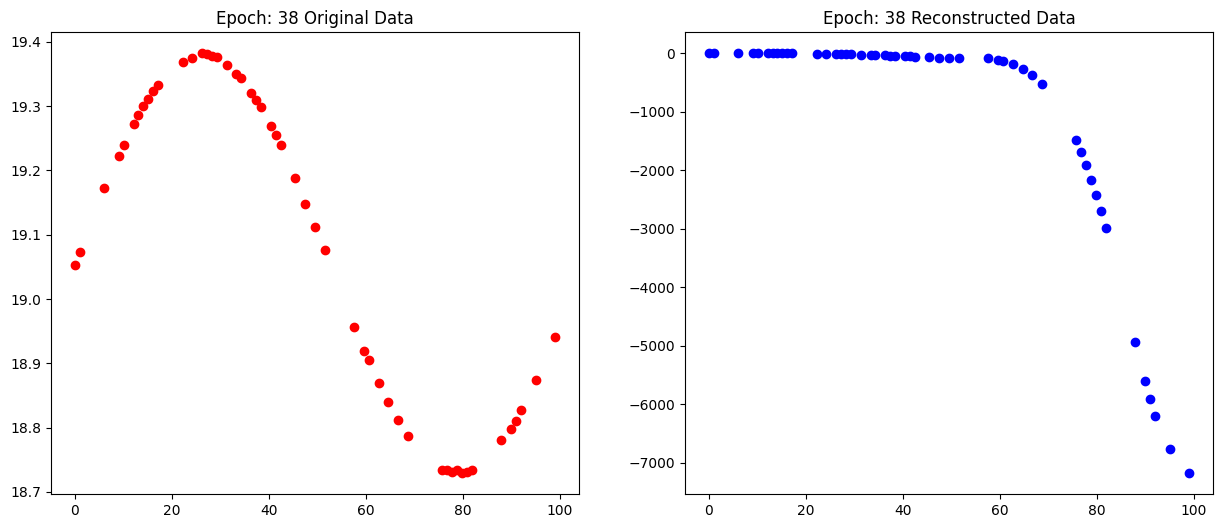

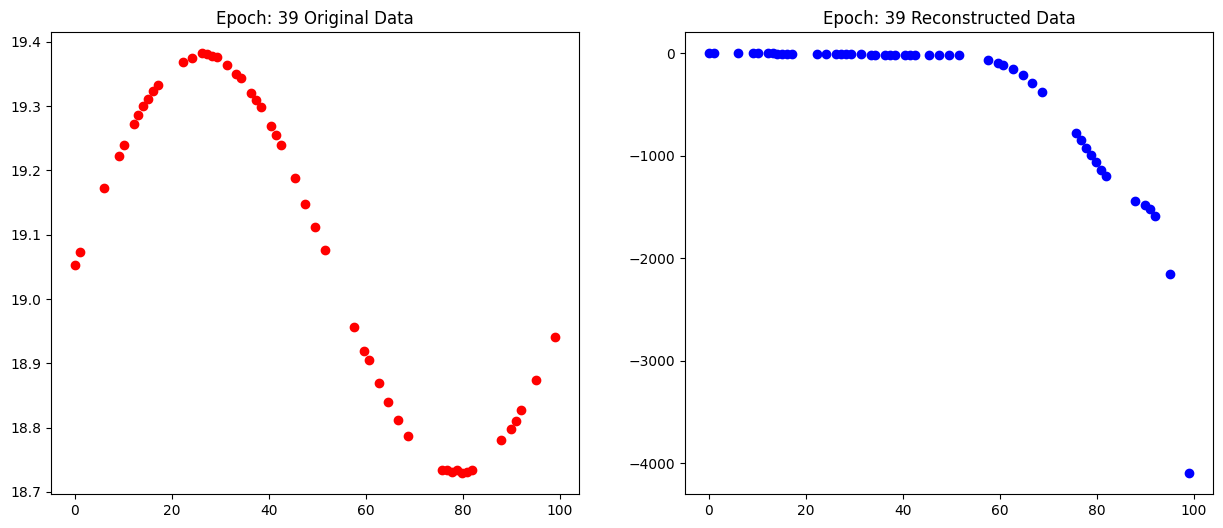

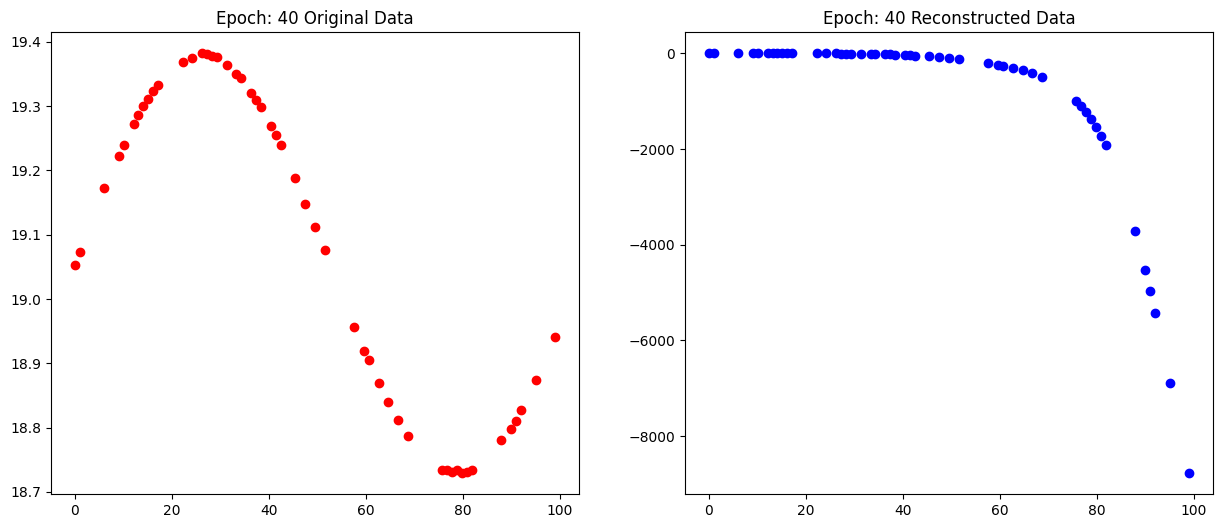

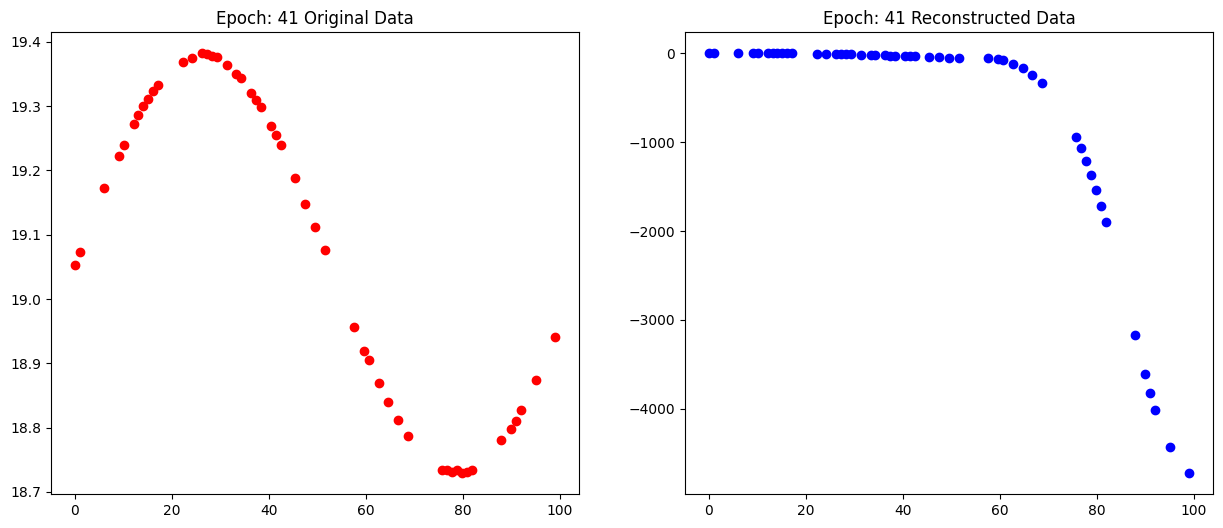

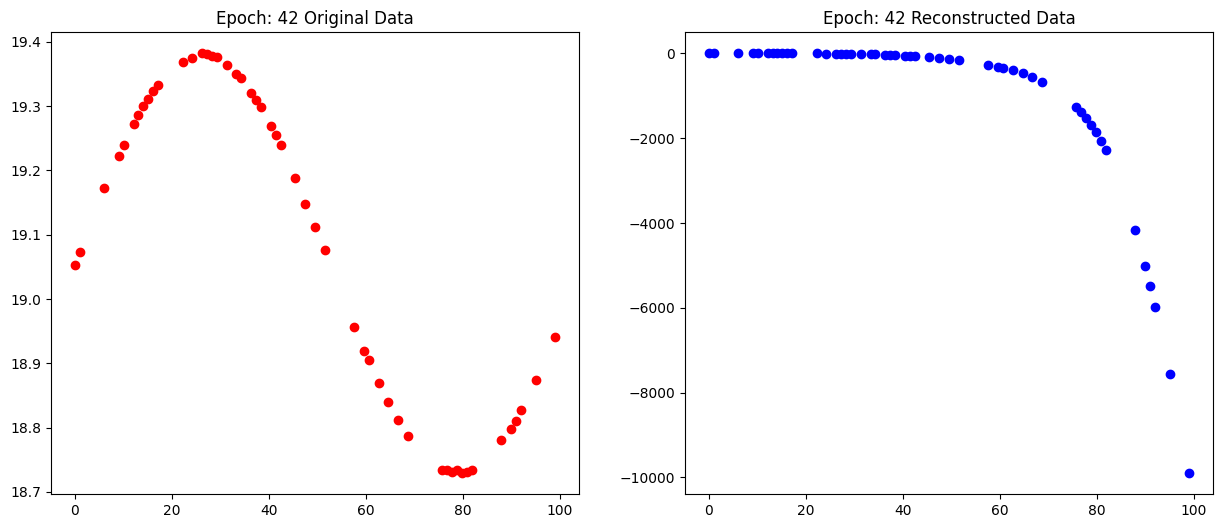

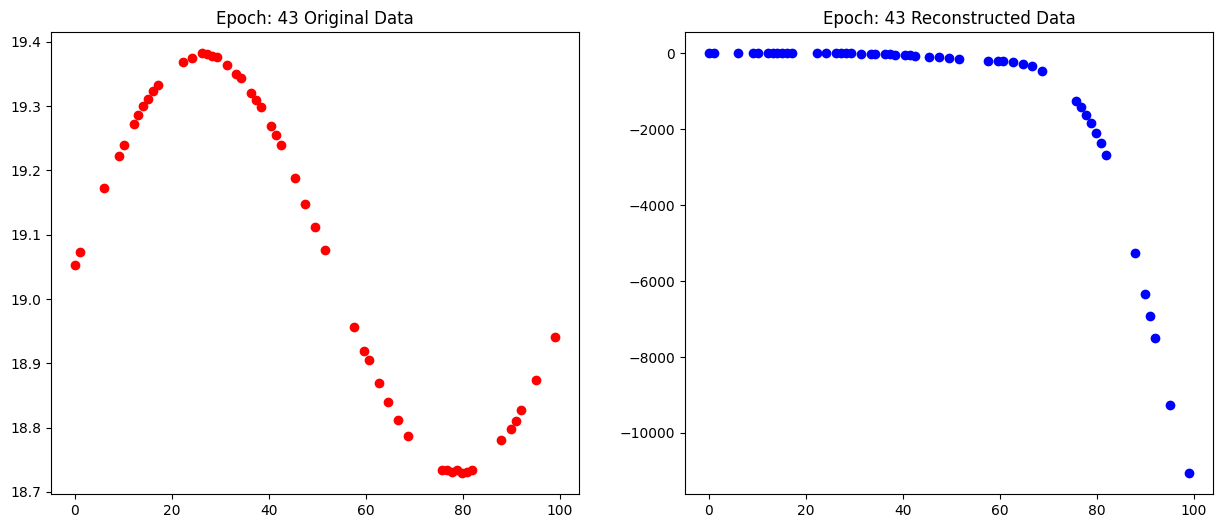

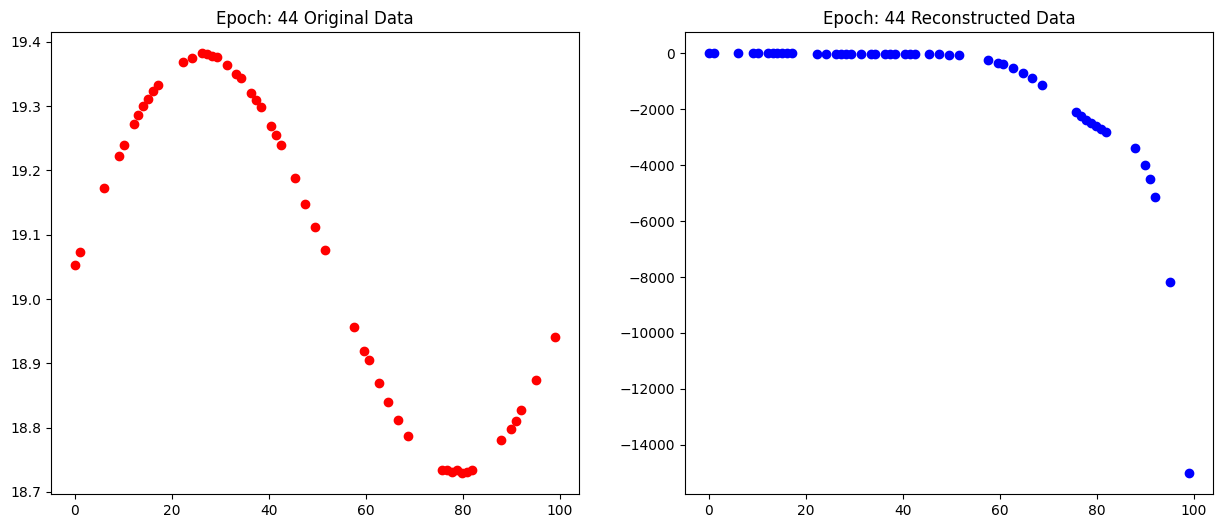

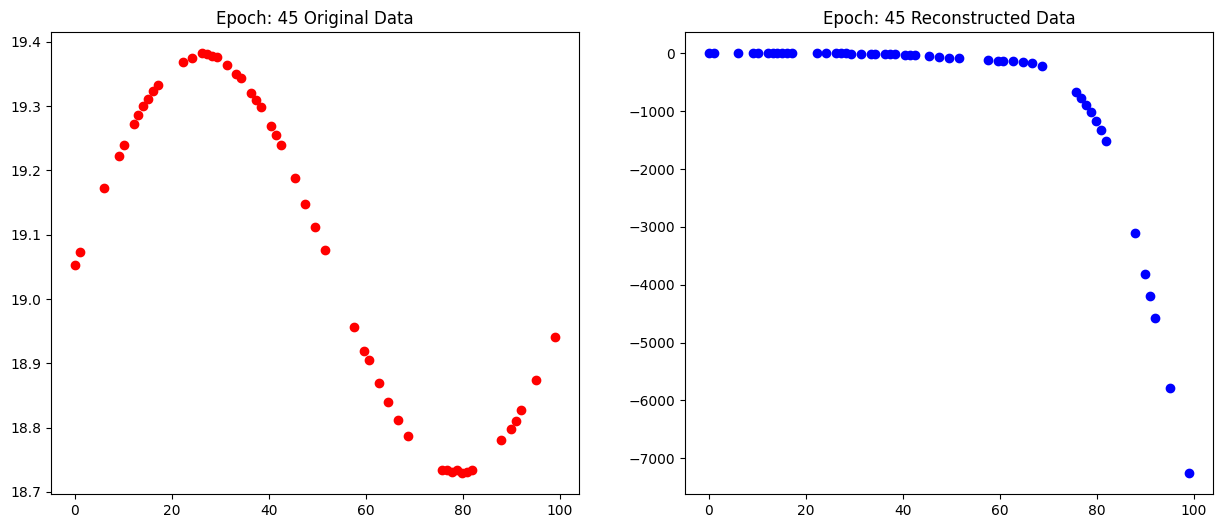

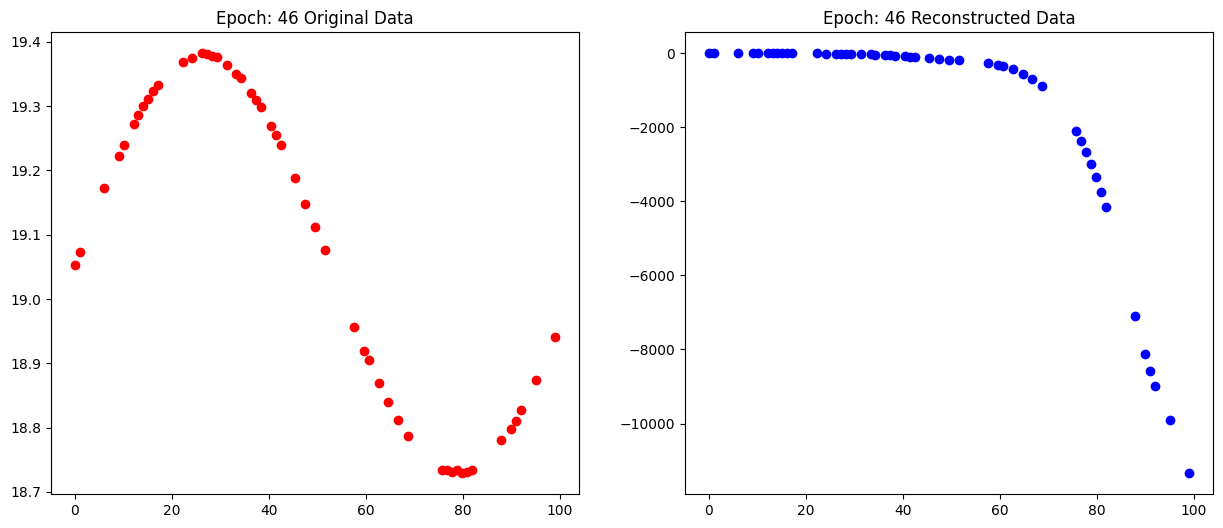